# A story of Bias in Machine Learning

<b>P. Besse</b> <i>(1)</i><b>, E. del Barrio</b> <i>(2)</i><b>, P. Gordaliza</b> <i>(1,2)</i><b>, J.-M. Loubes</b> <i>(1,3)</i><b>, L. Risser</b> <i>(1,3)</i>

<i>(1)</i> Institut de Mathematiques de Toulouse, INSA, Universite Toulouse 3, CNRS, Toulouse, France

<i>(2)</i>  Instituto de Matematicas de la Universidad de Valladolid, Dpto.  de Estadistica e Investigacion Operativa, Universidad de Valladolid, Valladolid, Spain

<i>(3)</i> Artificial and Natural Intelligence Toulouse Institute (3IA ANITI), Toulouse, France 

## Introduction

We will use in this notebook the Adult Income dataset, which is available on the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/adult). It consists in forecasting a binary variable (low or high income) which corresponds to an income lower or higher to 50k$ a year. This decision could be used to evaluate the credit risk and is considered here as sensitive to a discrimination. The variables X, and the true outcome Y are available, hence supervised machine learning algorithms will be used.

A total amount of 48.842 individuals are described by 14 variables. Let us load and have a quick look at this dataset.

In [35]:
# Importing the module
import os

# Printing the current working directory
print("The Current working directory is: {0}".format(os.getcwd()))

# Changing the current working directory
os.chdir('C:/Users/todof/Documents/Polytechnique/EA/StoryOfBias')

# Print the current working directory
print("The Current working directory now is: {0}".format(os.getcwd()))

The Current working directory is: C:\Users\todof\Documents\Polytechnique\EA\StoryOfBias
The Current working directory now is: C:\Users\todof\Documents\Polytechnique\EA\StoryOfBias


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk

original_data_train = pd.read_csv(
    "adult.data",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "OrigEthn", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
    sep=r'\s*,\s*',
    engine='python',
    na_values="?")

original_data_test = pd.read_csv(
    "adult.test",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "OrigEthn", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
    sep=r'\s*,\s*',
    engine='python',
    na_values="?")


original_data = pd.concat([original_data_test,original_data_train])
original_data.reset_index(inplace = True, drop = True)

original_data.tail()



,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,OrigEthn,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
48838,27,Private,257302.0,Assoc-acdm,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States,<=50K
48839,40,Private,154374.0,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
48840,58,Private,151910.0,HS-grad,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States,<=50K
48841,22,Private,201490.0,HS-grad,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States,<=50K
48842,52,Self-emp-inc,287927.0,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024.0,0.0,40.0,United-States,>50K


Inspired by https://www.valentinmihov.com/2015/04/17/adult-income-data-set/, we can also plot the distribution of each feature, so that we have a better understanding what we have in our data. We draw the number of values for each category feature and the histogram of the values for each continuous feature.

C:\Users\todof\AppData\Local\Temp\ipykernel_10324\3082632256.py:7: DeprecationWarning: in the future the `.dtype` attribute of a given datatype object must be a valid dtype instance. `data_type.dtype` may need to be coerced using `np.dtype(data_type.dtype)`. (Deprecated NumPy 1.20)
  if original_data.dtypes[column] == np:


C:\Users\todof\AppData\Local\Temp\ipykernel_10324\3082632256.py:7: DeprecationWarning: in the future the `.dtype` attribute of a given datatype object must be a valid dtype instance. `data_type.dtype` may need to be coerced using `np.dtype(data_type.dtype)`. (Deprecated NumPy 1.20)
  if original_data.dtypes[column] == np:
C:\Users\todof\AppData\Local\Temp\ipykernel_10324\3082632256.py:7: DeprecationWarning: in the future the `.dtype` attribute of a given datatype object must be a valid dtype instance. `data_type.dtype` may need to be coerced using `np.dtype(data_type.dtype)`. (Deprecated NumPy 1.20)
  if original_data.dtypes[column] == np:
C:\Users\todof\AppData\Local\Temp\ipykernel_10324\3082632256.py:7: DeprecationWarning: in the future the `.dtype` attribute of a given datatype object must be a valid dtype instance. `data_type.dtype` may need to be coerced using `np.dtype(data_type.dtype)`. (Deprecated NumPy 1.20)
  if original_data.dtypes[column] == np:
C:\Users\todof\AppData\Local

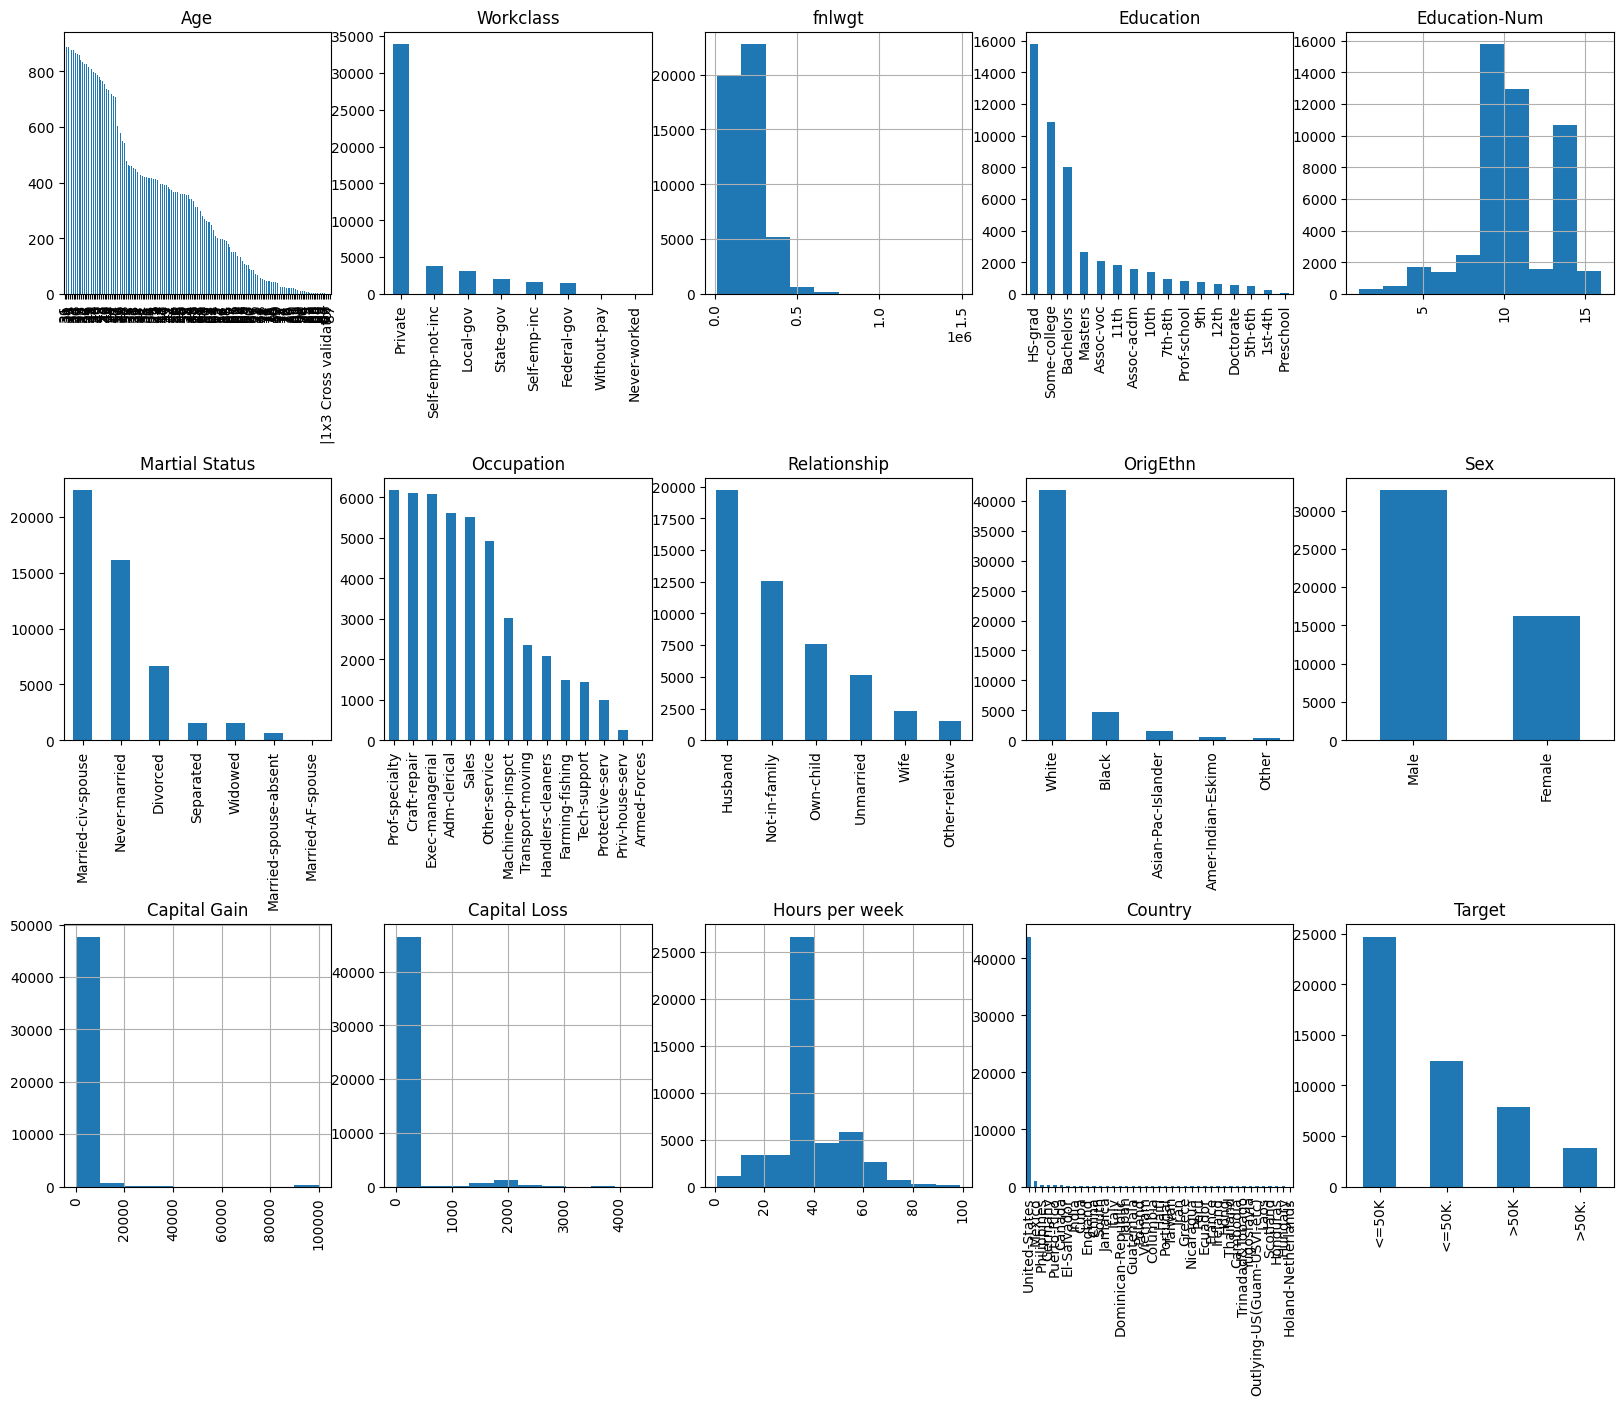

In [37]:

fig = plt.figure(figsize=(20,15))
cols = 5
rows = np.ceil(float(original_data.shape[1]) / cols)
for i, column in enumerate(original_data.columns):
    ax = fig.add_subplot(int(rows), int(cols), i + 1)
    ax.set_title(column)
    if original_data.dtypes[column] == np:
        original_data[column].value_counts().plot(kind="bar", axes=ax)
    else:
        original_data[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)
plt.show()

This representation of the data gives a good overview of what this dataset contains. It also makes clear that it has to be pre-processed before its analysis using black-box machine learning algorithms. For instance, the variable <i>"fnlwgt"</i> has no clear interpretation and only two labels would make much more sense than four in the variable <i>"Target"</i>. A variable like <i>"Country"</i> (see below) also appears as too refined to capture potential discriminations, so using only the variable <i>"OrigEthn"</i> is reasonable. 

In [38]:
(original_data["Country"].value_counts() / original_data.shape[0]).head()

United-States    0.897406
Mexico           0.019471
Philippines      0.006040
Germany          0.004218
Puerto-Rico      0.003767
Name: Country, dtype: float64

## 1 Statistical Analysis of the Dataset

### 1.1 Data preparation

As discussed in the introduction, we will first prepare the data to give clear interpretation to further analyses. The variable fnlwgt (Final sampling weight) (http://web.cs.wpi.edu/~cs4341/C00/Projects/fnlwgt) has no clear meaning, so it will be removed. Missing data wil be removed, some incoherent data will be replaced, redundant variables will be removed, and some classes will be finally gathered regrouped in order to gain more statistical insight. Note however that Friedler et al. (2019) analysed the raw dataset.

These modifications are applied in the cell below:
<ul>
  <li>Binary variable <i>"Child"</i> is created. It indicates whether the person has kids or not.</li>
  <li>Variable <i>"OrigEthn"</i> is transformed into a binary variable: <i>"CaucYes"</i> vs. <i>"CaucNo"</i>.</li>
  <li>Variable <i>"fnlwgt"</i> is removed, as its meaning is not clear.</li>
  <li>Varible <i>"Country"</i> is removed as redundant with variable <i>"OrigEthn"</i>.</li>
  <li>Varible <i>"Education"</i> is removed as redundant with variable <i>"Education-Num"</i>.</li>
  <li>Variable <i>"Relationship"</i> is removed as redundant with variable <i>"Martial Status"</i>.</li>
  <li>Additionally clean-up the <i>&lt;=50K</i>, <i>&lt;=50K.</i>, <i>>50K</i> and <i>>50K.</i> in  variable <i>"Target"</i></li>
</ul>





In [39]:
data=original_data.copy()


data['Child'] = np.where(data['Relationship']=='Own-child', 'ChildYes', 'ChildNo')
data['OrigEthn'] = np.where(data['OrigEthn']=='White', 'CaucYes', 'CaucNo')

data=data.drop(columns=['fnlwgt','Relationship','Country','Education'])

data=data.replace('<=50K.','<=50K')
data=data.replace('>50K.','>50K')

data.tail()


,Age,Workclass,Education-Num,Martial Status,Occupation,OrigEthn,Sex,Capital Gain,Capital Loss,Hours per week,Target,Child
48838,27,Private,12.0,Married-civ-spouse,Tech-support,CaucYes,Female,0.0,0.0,38.0,<=50K,ChildNo
48839,40,Private,9.0,Married-civ-spouse,Machine-op-inspct,CaucYes,Male,0.0,0.0,40.0,>50K,ChildNo
48840,58,Private,9.0,Widowed,Adm-clerical,CaucYes,Female,0.0,0.0,40.0,<=50K,ChildNo
48841,22,Private,9.0,Never-married,Adm-clerical,CaucYes,Male,0.0,0.0,20.0,<=50K,ChildYes
48842,52,Self-emp-inc,9.0,Married-civ-spouse,Exec-managerial,CaucYes,Female,15024.0,0.0,40.0,>50K,ChildNo


C:\Users\todof\AppData\Local\Temp\ipykernel_10324\569855568.py:7: DeprecationWarning: in the future the `.dtype` attribute of a given datatype object must be a valid dtype instance. `data_type.dtype` may need to be coerced using `np.dtype(data_type.dtype)`. (Deprecated NumPy 1.20)
  if data.dtypes[column] == np:


C:\Users\todof\AppData\Local\Temp\ipykernel_10324\569855568.py:7: DeprecationWarning: in the future the `.dtype` attribute of a given datatype object must be a valid dtype instance. `data_type.dtype` may need to be coerced using `np.dtype(data_type.dtype)`. (Deprecated NumPy 1.20)
  if data.dtypes[column] == np:
C:\Users\todof\AppData\Local\Temp\ipykernel_10324\569855568.py:7: DeprecationWarning: in the future the `.dtype` attribute of a given datatype object must be a valid dtype instance. `data_type.dtype` may need to be coerced using `np.dtype(data_type.dtype)`. (Deprecated NumPy 1.20)
  if data.dtypes[column] == np:
C:\Users\todof\AppData\Local\Temp\ipykernel_10324\569855568.py:7: DeprecationWarning: in the future the `.dtype` attribute of a given datatype object must be a valid dtype instance. `data_type.dtype` may need to be coerced using `np.dtype(data_type.dtype)`. (Deprecated NumPy 1.20)
  if data.dtypes[column] == np:
C:\Users\todof\AppData\Local\Temp\ipykernel_10324\56985556

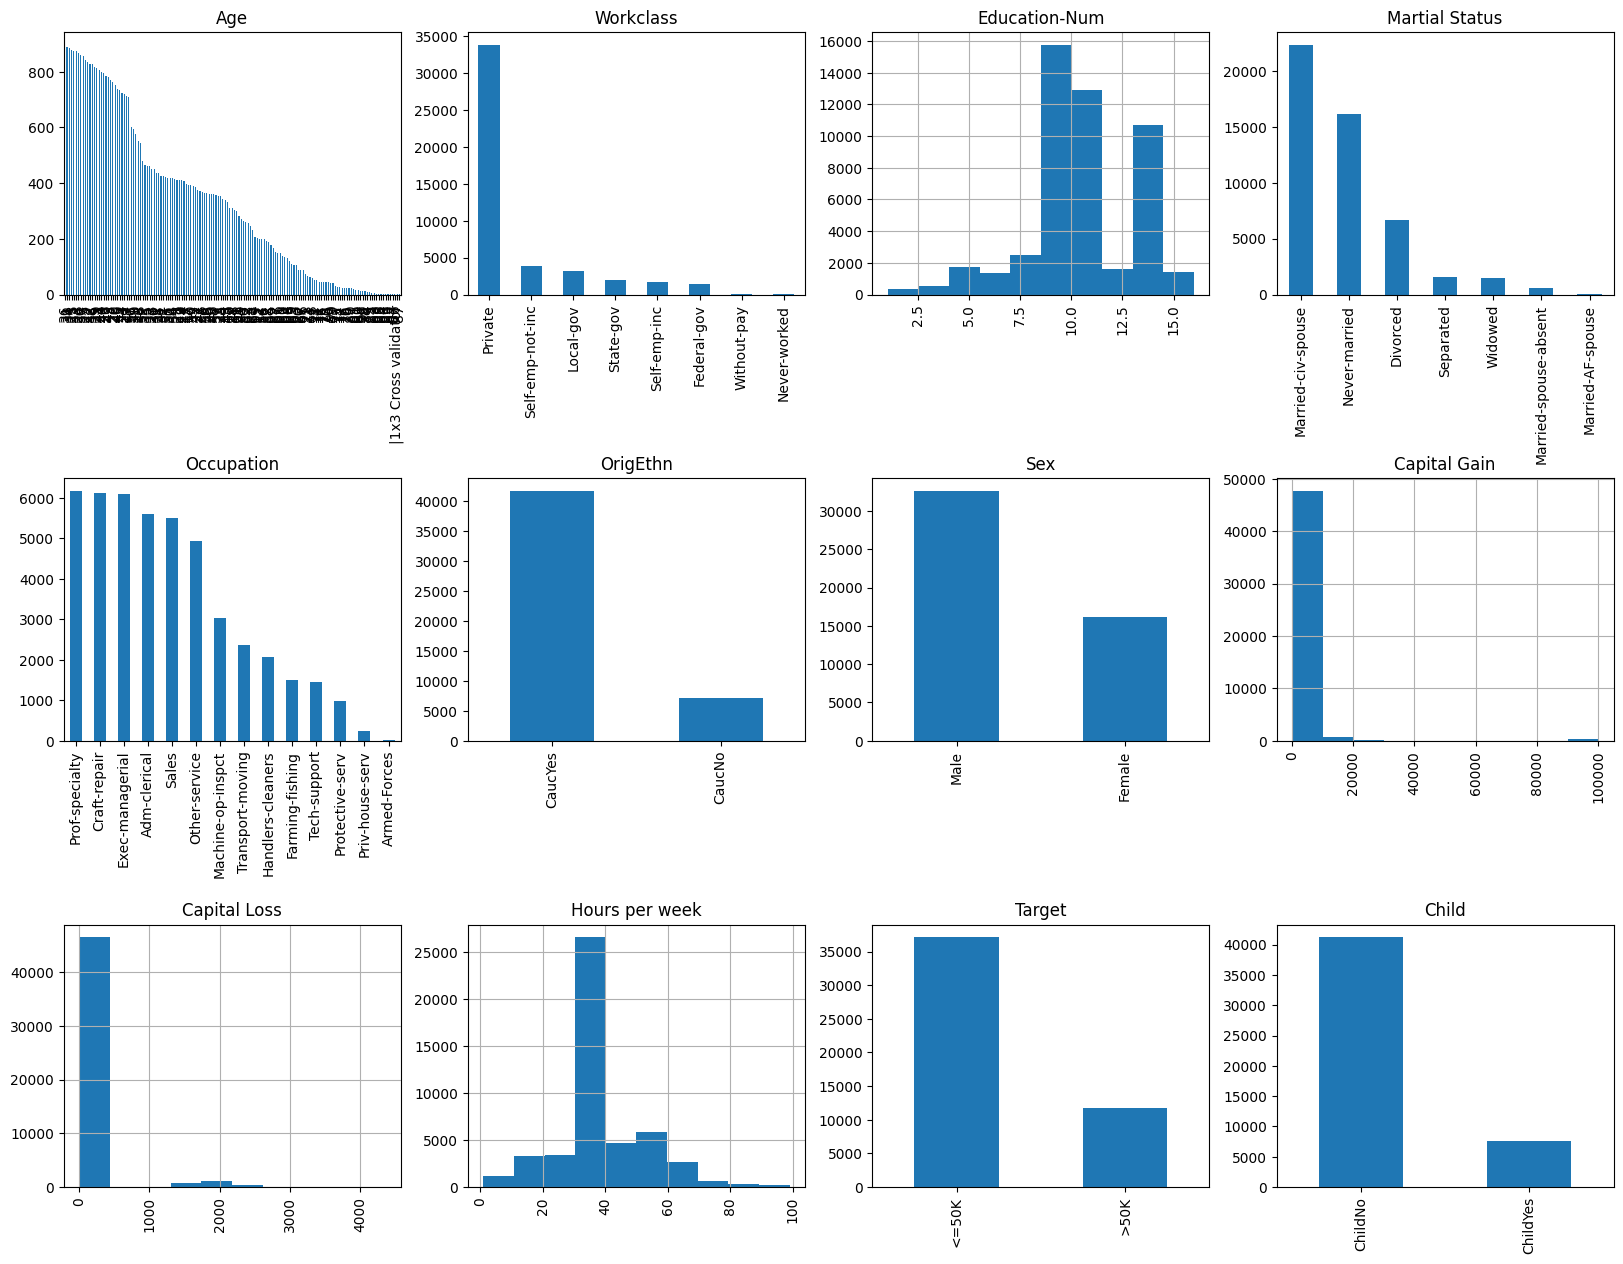

In [40]:
fig = plt.figure(figsize=(20,15))
cols = 4
rows = np.ceil(float(data.shape[1]) / cols)
for i, column in enumerate(data.columns):
    ax = fig.add_subplot(int(rows), int(cols), i + 1)
    ax.set_title(column)
    if data.dtypes[column] == np:
        data[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)
plt.show()


### 1.2 Unbalanced Learning Sample



The following tables shows first the unbalance in the repartition of the target variable and the sex, then between the target and the ethnic origin.


In [42]:
from statsmodels.graphics.mosaicplot import mosaic

print('Mosaic plot:')
mosaic(data, ['Sex','Target'],gap=0.02)
plt.savefig('figbias1.pdf')
plt.show()


Mosaic plot:


NameError: name 'mosaic' is not defined

In [43]:

print('Mosaic plot:')
mosaic(data, index=['OrigEthn','Target' ],gap=0.02)
plt.savefig('figbias2.pdf')

plt.show()

Mosaic plot:


NameError: name 'mosaic' is not defined

### 1.3 Conclusion

What is the information that will be learnt from the data? A relationship between the variables and the <i>Capital Gains</i> that will enable its forecast or the mere bias in the repartition of the <i>Capital Gains</i> with respect to the variables <i>sex</i> and <i>ethnic origin</i>, because of an unbalanced dataset ?


## 2 Machine Learning Algorithms to forecast income

### 2.1 Supervised Learning Algorithms and One-hot encoding

We will compare the three following type of algorithms:

<ul>
  <li>Logistic regression.</li>
  <li>Decision tree.</li>
  <li>Gradient boosting.</li>
</ul>

In order to analyze categorial features using different machine learning models, binary categorial variables will be encoded using 0 or 1. The categorial variables with more than two classed we will be transformed into one-hot vectors, i.e. vectors where only one element is non-zero (or hot).

In [175]:
data_ohe=data.copy()

data_ohe['Target'] = np.where(data_ohe['Target']=='>50K', 1., 0.)
print(' -> In column Target: label >50K gets 1.')

data_ohe['OrigEthn'] = np.where(data_ohe['OrigEthn']=='CaucYes', 1., 0.)
print(' -> In column '+str('OrigEthn')+': label '+str('CaucYes')+' gets 1.')

data_ohe['Sex'] = np.where(data_ohe['Sex']=='Male', 1., 0.)
print(' -> In column '+str('Sex')+': label '+str('Male')+' gets 1.')

for col in ['Workclass', 'Martial Status', 'Occupation', 'Child']:
    if len(set(list(data_ohe[col])))==2:
        LabelThatGets1=data_ohe[col][0]
        data_ohe[col] = np.where(data_ohe[col]==LabelThatGets1, 1., 0.)
        print(' -> In column '+str(col)+': label '+str(LabelThatGets1)+' gets 1.')
    else:
        print(' -> In column '+str(col)+': one-hot encoding conversion with labels '+str(set(list(data_ohe[col]))))
        data_ohe=pd.get_dummies(data_ohe,prefix=[col],columns=[col])

data_ohe.tail()

 -> In column Target: label >50K gets 1.
 -> In column OrigEthn: label CaucYes gets 1.
 -> In column Sex: label Male gets 1.
 -> In column Workclass: one-hot encoding conversion with labels {'Federal-gov', 'Self-emp-inc', 'Private', None, 'Never-worked', 'Local-gov', 'State-gov', nan, 'Self-emp-not-inc', 'Without-pay'}
 -> In column Martial Status: one-hot encoding conversion with labels {'Widowed', 'Married-spouse-absent', 'Married-civ-spouse', 'Married-AF-spouse', None, 'Never-married', 'Separated', 'Divorced'}
 -> In column Occupation: one-hot encoding conversion with labels {'Sales', 'Other-service', 'Machine-op-inspct', 'Craft-repair', 'Farming-fishing', 'Tech-support', None, 'Transport-moving', 'Exec-managerial', 'Priv-house-serv', 'Protective-serv', 'Armed-Forces', 'Handlers-cleaners', nan, 'Prof-specialty', 'Adm-clerical'}
 -> In column Child: label ChildNo gets 1.


,Age,Education-Num,OrigEthn,Sex,Capital Gain,Capital Loss,Hours per week,Target,Child,Workclass_Federal-gov,...,Occupation_Farming-fishing,Occupation_Handlers-cleaners,Occupation_Machine-op-inspct,Occupation_Other-service,Occupation_Priv-house-serv,Occupation_Prof-specialty,Occupation_Protective-serv,Occupation_Sales,Occupation_Tech-support,Occupation_Transport-moving
48838,27,12.0,1.0,0.0,0.0,0.0,38.0,0.0,1.0,0,...,0,0,0,0,0,0,0,0,1,0
48839,40,9.0,1.0,1.0,0.0,0.0,40.0,1.0,1.0,0,...,0,0,1,0,0,0,0,0,0,0
48840,58,9.0,1.0,0.0,0.0,0.0,40.0,0.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0
48841,22,9.0,1.0,1.0,0.0,0.0,20.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
48842,52,9.0,1.0,0.0,15024.0,0.0,40.0,1.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0


In [177]:
data_ohe=data_ohe.iloc[1:]

Finally extract the input and output (X and y) matrices as np.arrays for further analyses using sklearn, and split them into a learning and test sample. 

In [178]:
#extract the X and y np.arrays
y=data_ohe['Target'].values.reshape(-1,1)

data_ohe_wo_target=data_ohe.drop(columns=['Target'])

X_col_names=list(data_ohe_wo_target.columns)
X=data_ohe_wo_target.values


#split the learning and test samples
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

#print the np.array shapes 
print('n_train=',X_train.shape[0])
print('n_test=',X_test.shape[0])
print('p=',X_test.shape[1])

#center-reduce the arrays X_train and X_test to make sure all variables have the same scale
X_train=sk.preprocessing.scale(X_train)
X_test_NoScaling=X_test.copy()
X_test=sk.preprocessing.scale(X_test)

n_train= 32724
n_test= 16118
p= 37




### 2.1 Logistic Regression

We first perform a <i>Logistic Regression</i> on these data.

In [179]:
from sklearn.linear_model import LogisticRegression

#instanciate the classifier
clf_LR = LogisticRegression(solver='lbfgs',max_iter=10000)

#train the classifier
clf_LR.fit(X_train,y_train.ravel())

#predict y_test
y_test_pred_LR=clf_LR.predict(X_test)

print('Done')

Done


Now the classifier is trained and the predictions are made on the test set, let's measure the accuracy of the predictions.<br>

We recall that:
<ul>
 <li>y=0 means an income below 50K</li>
 <li>y=1 means an income above 50K</li>
</ul>


and that a Confusion Matrix (C.M.) represents here the amount of:

$$
C.M. = 
\left(
\begin{array}{cc}
True  Negatives &False  Positives\\
False  Negatives &True  Positives\\
\end{array}
\right)
$$


In [167]:
from sklearn.metrics import accuracy_score
from sklearn import metrics

acc=accuracy_score(y_test.ravel(),y_test_pred_LR.ravel())
tpr=np.sum((y_test_pred_LR.ravel()==1)*(y_test.ravel()==1)) / np.sum(y_test_pred_LR.ravel()==1)
tnr=np.sum((y_test_pred_LR.ravel()==0)*(y_test.ravel()==0)) / np.sum(y_test_pred_LR.ravel()==0)

cm = metrics.confusion_matrix(y_test.ravel(),y_test_pred_LR.ravel(),labels=[0,1])

print("\nAccuracy =",acc)
print("True positive rate =",tpr)  #Rem: Equivalent to metrics.precision_score(y_test.ravel(), y_test_pred.ravel(), pos_label=1.)
print("True negative rate =",tnr)
print('\nConfusion matrix =')
print(cm)



Accuracy = 0.8511601935724036
True positive rate = 0.7442233632862645
True negative rate = 0.8767881864328565

Confusion matrix =
[[11400   797]
 [ 1602  2319]]



### 2.3 Decision tree

We now train a <i>Decsion tree</i> on the data, which has the interest to be straightforwardly interpretable.


In [246]:
from sklearn.tree import DecisionTreeClassifier

clf_DT=DecisionTreeClassifier(max_depth=5)
clf_DT.fit(X_train,y_train.ravel())

y_test_pred_DT = clf_DT.predict(X_test)

#*** Uncomment the three raws below to see the decision rules ***
#from sklearn import tree
#dot_data = tree.export_graphviz(DTC_clf)
#print(dot_data)

Let's see now the prediction accuracy

In [247]:
acc=accuracy_score(y_test.ravel(),y_test_pred_DT.ravel())
tpr=np.sum((y_test_pred_DT.ravel()==1)*(y_test.ravel()==1)) / np.sum(y_test_pred_DT.ravel()==1)
tnr=np.sum((y_test_pred_DT.ravel()==0)*(y_test.ravel()==0)) / np.sum(y_test_pred_DT.ravel()==0)

cm = metrics.confusion_matrix(y_test.ravel(),y_test_pred_DT.ravel(),labels=[0,1])

print("\nAccuracy =",acc)
print("True positive rate =",tpr)  #Rem: Equivalent to metrics.precision_score(y_test.ravel(), y_test_pred.ravel(), pos_label=1.)
print("True negative rate =",tnr)
print('\nConfusion matrix =')
print(cm)


Accuracy = 0.8464449683583571
True positive rate = 0.7579273008507347
True negative rate = 0.8633609222583506

Confusion matrix =
[[11683   626]
 [ 1849  1960]]


This is the best average result so far. Remark however that altough the prediction are clearly the best for the obesrvations with y=0, they are clearly poor for y=1, which contains about 24&percnt; of the observations. There are even more false positive than true positive predictions.


### 2.3 Gradient Boosting

We now train a <i>Gradient Boosting</i> classifier and test its efficiency.

In [57]:
#if not installed use the command: conda install -c conda-forge lightgbm
import lightgbm as lgb

clf_GB = lgb.LGBMClassifier(random_state=42)
clf_GB.fit(X_train, y_train.ravel())

y_test_pred_GB = clf_GB.predict(X_test)

ModuleNotFoundError: No module named 'lightgbm'

In [ ]:
acc=accuracy_score(y_test.ravel(),y_test_pred_GB.ravel())
tpr=np.sum((y_test_pred_GB.ravel()==1)*(y_test.ravel()==1)) / np.sum(y_test_pred_GB.ravel()==1)
tnr=np.sum((y_test_pred_GB.ravel()==0)*(y_test.ravel()==0)) / np.sum(y_test_pred_GB.ravel()==0)

cm = metrics.confusion_matrix(y_test.ravel(),y_test_pred_GB.ravel(),labels=[0,1])

print("\nAccuracy =",acc)
print("True positive rate =",tpr)  #Rem: Equivalent to metrics.precision_score(y_test.ravel(), y_test_pred.ravel(), pos_label=1.)
print("True negative rate =",tnr)
print('\nConfusion matrix =')
print(cm)


Accuracy = 0.8523389998759151
True positive rate = 0.7419768934531451
True negative rate = 0.8787878787878788

Confusion matrix =
[[11426   804]
 [ 1576  2312]]


### Classfication with positive discrimination

In [192]:
import random
def discriminate(X,y, p):
    n=len(y.ravel())
    nb_changes=int(n*p)
    # Randomly select and change the values
    indices_to_change = random.sample(range(n), nb_changes)
    z=y
    for idx in indices_to_change:
        if X[idx][X_col_names.index('Sex')]<0 and z[idx]==0.0:
            z[idx] = 1 - z[idx]
    return z



In [249]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

# Define the number of splits (k) for cross-validation
num_splits = 10
disc_rate=0.0 #1 for full discrimination, 0 for no discrimination 
known_DI=0.35
p=0
C=1.5
clf_disc=DecisionTreeClassifier(max_depth=5)

S=X_test_NoScaling[:,X_col_names.index('Sex')].ravel()




# Create a KFold object to split the data
kf = KFold(n_splits=num_splits, shuffle=True, random_state=41)

# Split your data and train the model on each split
for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train.ravel()[train_index], y_train.ravel()[test_index]


    # Train the model on the current fold
    clf_disc.fit(X_train_fold, discriminate(X_train_fold, y_train_fold,p))
    y_test_pred_fold = clf_disc.predict(X_test_fold)
    acc=accuracy_score(y_test_fold.ravel(),y_test_pred_fold.ravel())
    tpr=np.sum((y_test_pred_fold.ravel()==1)*(y_test_fold.ravel()==1)) / np.sum(y_test_pred_fold.ravel()==1)
    tnr=np.sum((y_test_pred_fold.ravel()==0)*(y_test_fold.ravel()==0)) / np.sum(y_test_pred_fold.ravel()==0)

    cm = metrics.confusion_matrix(y_test_fold.ravel(),y_test_pred_fold.ravel(),labels=[0,1])

    print("\nAccuracy =",acc)
    print("True positive rate =",tpr)  #Rem: Equivalent to metrics.precision_score(y_test.ravel(), y_test_pred.ravel(), pos_label=1.)
    print("True negative rate =",tnr)
    print('\nConfusion matrix =')
    print(cm)

    S=X_test_fold[:,X_col_names.index('Sex')].ravel()
    DI=len([i for i in range(len(S)) if (y_test_pred_fold[i]==1.0 and S[i]<0)])/ len([i for i in range(len(S)) if (y_test_pred_fold[i]==1.0 and S[i]>0)])
    print('DI:',DI)
    if (known_DI-DI)*C>0 and (known_DI-DI)*C<1:
        p=(known_DI-DI)*C
        print(p)
    

    
print('-------------------TOTAL----------------------')

from sklearn.tree import DecisionTreeClassifier
y_test_pred_disc= clf_disc.predict(X_test)

acc=accuracy_score(y_test.ravel(),y_test_pred_disc.ravel())
tpr=np.sum((y_test_pred_disc.ravel()==1)*(y_test.ravel()==1)) / np.sum(y_test_pred_disc.ravel()==1)
tnr=np.sum((y_test_pred_disc.ravel()==0)*(y_test.ravel()==0)) / np.sum(y_test_pred_disc.ravel()==0)

cm = metrics.confusion_matrix(y_test.ravel(),y_test_pred_disc.ravel(),labels=[0,1])

print("\nAccuracy =",acc)
print("True positive rate =",tpr)  #Rem: Equivalent to metrics.precision_score(y_test.ravel(), y_test_pred.ravel(), pos_label=1.)
print("True negative rate =",tnr)
print('\nConfusion matrix =')
print(cm)


S=X_test_NoScaling[:,X_col_names.index('Sex')].ravel()

y_test_pred_disc = clf_disc.predict(X_test).ravel()
DI=len([i for i in range(len(S)) if (y_test_pred_disc[i]==1 and S[i]==0)])/ len([i for i in range(len(S)) if (y_test_pred_disc[i]==1 and S[i]==1)])


print('DI y_test_pred_disc =',DI)



Accuracy = 0.8481515429269783
True positive rate = 0.783427495291902
True negative rate = 0.8606856309263311

Confusion matrix =
[[2360  115]
 [ 382  416]]
DI: 0.14935064935064934
0.30097402597402595

Accuracy = 0.8502902535899786
True positive rate = 0.798828125
True negative rate = 0.8598333936979355

Confusion matrix =
[[2374  103]
 [ 387  409]]
DI: 0.1277533039647577
0.3333700440528634

Accuracy = 0.8282920867705469
True positive rate = 0.6777408637873754
True negative rate = 0.8622238861849495

Confusion matrix =
[[2303  194]
 [ 368  408]]
DI: 0.36507936507936506

Accuracy = 0.8313473877176902
True positive rate = 0.7299509001636661
True negative rate = 0.8546205860255447

Confusion matrix =
[[2275  165]
 [ 387  446]]
DI: 0.3311546840958606
0.028267973856209105

Accuracy = 0.8398533007334963
True positive rate = 0.755859375
True negative rate = 0.8554347826086957

Confusion matrix =
[[2361  125]
 [ 399  387]]
DI: 0.1277533039647577
0.3333700440528634

Accuracy = 0.825183374083129

## 3 Measuring the Bias

### 3.1 Definition


Different definitions of bias in a data set or induced by the decisions of an algorithm have been proposed in the statistical litterature. Among them we will consider the so-called demographic parity.

Consider the following Notations:

<ul>
  <li>$Y$ is the variable to be forecast or explained. We consider here binary variables where $Y=1$ is a positive decision (<i>i.e.</i> a high income) while $Y=0$ is a low income;</li>
  <li>$g(X)=\hat{Y}$ is the prediction given by the algorithm. It can be either a score or a binary variable, small scores leading to the forecast $\hat{Y}=0$ while larger scores entail $\hat{Y}=1$.</li>
  <li>$S$ is the variable which divides the population into groups that may be treated in a different way, hence inducing a bias. From a legal or moral point of view $S$ is a sensitive variable which should not influence the decision otherwise it will lead to a discriminative decision. Hereafter we consider the case where $S=1$ is the majority while $S=0$ is the minority that could be discriminated (male v.s female or caucasian v.s non caucasian).</li>
</ul>

A way to measure this possible is the disparate impact [Biddle D. 2005]. We will first consiter the general Disparate Impact which measures the bias already existing in the dataset as follows.

$$ DI = \frac{\mathbb{P}(Y=1 | S=0)}{\mathbb{P}(Y=1 | S=1)}$$

It can be easily estimated as 

$$ \frac{n_{21}}{(n_{11}+n_{21})}  /  \frac{n_{22}}{(n_{12}+n_{22})}$$

where $n_{ij}$ is ... . This notion of DI can be extended to the outcome of an algorithm by replacing the true variable $Y$ by $g(X)=\hat{Y}$. 

$$ DI = \frac{\mathbb{P}(\hat{Y}=1 | S=0)}{\mathbb{P}(\hat{Y}=1 | S=1)}$$

This measures the bias of the forecast and thus constitutes the risk of a discrimination.

Actually fairness induced by the demographic parity criterion means that the decision should not depend on the sensitive (or protected) variable. Hence the random variables $\hat{Y}$ 
should be independent of $S$. So the disparate impact $DI(g)$ should be close to $1$ for a completely fair decision, or at least should not be smaller than the general disparate impact $DI$. The smaller the disparate, the more discrimination over the minority group is at stake.

Note that other discrimination measures can be used and are described in [Hardt et al. 2016].




### 3.2 Estimation of the disparate impact

#### Function dispImp

Providing an estimation of the $DI$ can be easily done by considering the empirical version of the integrated criterion. Yet this estimation is unstable due to the unbalance in the sample. So we propose to estimate a score and a confidence interval around this score in order to provide more statistical guarantees. This method is detailled in [Besse et al. 2018]. We provide a Python function to compute it. This function takes as entry

<ul>
  <li> the variable $S$: This is a np.array vector with two possible values, the first is a minority (S[i]=0) while the second is a majority (S[i]=1).</li>
  <li>The true target $Y$ or its forecast $g(X)=\hat{Y}$: This is again a np.array vector with two possible values, first the negative decision (Y[i]=0) and then the positive decision (Y[i]=1).</li>
  <li>The level of the confidence interval, default value is $5\%$. It can be changed by specifying the parameter <i>alpha</i>.</li>
</ul>

This function returns a list of three values corresponding to respectively the disparate impact ($DI$), and the lower and upper bounds of the confidence interval ($IC_g$ and $IC_d$).


In [ ]:
from FinalBiasAnalysis_complement import dispImp


### 3.3 Bias in the Adult data

#### Disparate Impact with respect to Sex


In [ ]:
S=X[:,X_col_names.index('Sex')].ravel()

[DI,ICg,ICd]=dispImp(S,y.ravel())

print("Disparate Impact="+str(DI))
print("Confidence interval=["+str(ICg)+","+str(ICd)+"]")

Disparate Impact=0.35965526258003366
Confidence interval=[0.34277074247343386,0.37653978268663346]


#### Disparate Impact with respect to the ethnic origin


In [ ]:
S=X[:,X_col_names.index('OrigEthn')].ravel()

[DI,ICg,ICd]=dispImp(S,y.ravel())

print("Disparate Impact="+str(DI))
print("Confidence interval=["+str(ICg)+","+str(ICd)+"]")

Disparate Impact=0.6005915505110953
Confidence interval=[0.5661712853880745,0.635011815634116]


Conclusion : the DI highlights the bias already present in the original dataset. The bias is worse when considering the sex difference.

### 3.4 Bias of Machine Learning Algorithms


We now compute the Disparate Impact using the models trained previously: logistic regression, tree and random Forest. We do it first for the sex and then for the ethnic origin.

#### Variable Sex




In [ ]:
S=X_test_NoScaling[:,X_col_names.index('Sex')].ravel()

[DI,ICg,ICd]=dispImp(S,y_test.ravel())
print('DI y_test =',DI)


y_test_pred_LR = clf_LR.predict(X_test)
[DI,ICg,ICd]=dispImp(S,y_test_pred_LR.ravel()) #Logistic Regression
print('DI y_test_pred_LR =',DI)

y_test_pred_DT = clf_DT.predict(X_test)
[DI,ICg,ICd]=dispImp(S,y_test_pred_DT.ravel()) #Decision tree
print('DI y_test_pred_DT =',DI)

y_test_pred_GB = clf_GB.predict(X_test)
[DI,ICg,ICd]=dispImp(S,y_test_pred_GB.ravel()) #Gradient boosting
print('DI y_test_pred_GB =',DI)

DI y_test = 0.3346274789656368
DI y_test_pred_LR = 0.21927852652385738
DI y_test_pred_DT = 0.25657476616414976
DI y_test_pred_GB = 0.2850936834229547


The disparate impact with respect to the variable <i>Sex</i> is clearly below 0.8 with the true $y$. The key message here is however that this disparate impact with even worsen using all trained predictors here. 


#### Variable OrigEthn




In [ ]:
S=X_test_NoScaling[:,X_col_names.index('OrigEthn')].ravel()

[DI,ICg,ICd]=dispImp(S,y_test.ravel())
print('DI y_test =',DI)

y_test_pred_LR = clf_LR.predict(X_test)
[DI,ICg,ICd]=dispImp(S,y_test_pred_LR.ravel()) #Logistic Regression
print('DI y_test_pred_LR =',DI)

y_test_pred_DT = clf_DT.predict(X_test)
[DI,ICg,ICd]=dispImp(S,y_test_pred_DT.ravel()) #Decision tree
print('DI y_test_pred_DT =',DI)

y_test_pred_GB = clf_GB.predict(X_test)
[DI,ICg,ICd]=dispImp(S,y_test_pred_GB.ravel()) #Gradient boosting
print('DI y_test_pred_GB =',DI)

DI y_test = 0.5928023934542129
DI y_test_pred_LR = 0.4953960275708802
DI y_test_pred_DT = 0.6351870363277207
DI y_test_pred_GB = 0.5089617198669015


As for the variable <i>Sex</i>, the disparate impact with respect to the ethnic origin is below $0.8$ using the true $y$. This time it remained globally stable using the tested machine learning models. One has to be carefull anyway when training decision rules, that they can worsen existing discrimination in the database.

### 3.5  Assessing DI for the algorithm using K-folds

As pointed out in Friedler et al. (2019), there is a strong variability when computing the disparate impact for different subsamples of the data.

The following code enables to cross-validate such results using 10 replications of different learning and test sample on which the three algorithms were trained: linear logistic, decision tree and random forest. The DI is then computed on the test sample.



In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

#from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier
#import lightgbm as lgb

def Make_Kfold_boxplots(list_classifiers,list_classifierNames,S,X,y,nsplits,printAverageRes=False,printAverageConfusionMatrices=False,Show_DI_boxPlotsOnly=False,PrefixFigNames='cur'):
    """
    Generate boxplots of the discriminate impacts and the accuracies 
    obtained on different classifier on the data [X,y]. The label of
    the sensitive variable for each observation is in S.
    """
    
    #1) create the lists in which the DI and the accuracies will be stored
    lst_DI_Ref=[]
    lst_DI_clfs=[]
    for i in range(len(list_classifiers)):
        lst_DI_clfs.append([])

    lst_Acc_clfs=[]
    for i in range(len(list_classifiers)):
        lst_Acc_clfs.append([])
    
    lst_tnr=[]
    lst_tnr_S0=[]
    lst_tnr_S1=[]
    for i in range(len(list_classifiers)):
        lst_tnr.append([])
        lst_tnr_S0.append([])
        lst_tnr_S1.append([])
    
    lst_tpr=[]
    lst_tpr_S0=[]
    lst_tpr_S1=[]
    for i in range(len(list_classifiers)):
        lst_tpr.append([])
        lst_tpr_S0.append([])
        lst_tpr_S1.append([])
    
    
    if printAverageConfusionMatrices==True:
        lst_CM=[]
        for i in range(len(list_classifiers)):
            lst_CM.append(np.zeros((2,2)))
    
    #2) Use 10-fold cross-validation to measure the strategies accuracy and D.I.
    kf = KFold(n_splits=nsplits,shuffle=True)
    for train, test in kf.split(X):
        #split the train and test data
        X_train=X[train]
        y_train=y[train]
        X_test=X[test]
        y_test=y[test]
        S_test=S[test]
        
        #add the D.I. of the true tested data 
        [DI_Ref,ICg,ICd]=dispImp(S_test.ravel(),y_test.ravel())
        lst_DI_Ref.append(DI_Ref)
        
        #train the three classifiers and predict y on the test data
        for i in range(len(list_classifiers)):
            list_classifiers[i].fit(X_train,y_train.ravel())
            y_test_pred=list_classifiers[i].predict(X_test)
            
            [DI_clf,ICg,ICd]=dispImp(S_test.ravel(),y_test_pred.ravel())
            lst_DI_clfs[i].append(DI_clf)
            
            acc_clf=accuracy_score(y_test.ravel(),y_test_pred.ravel())
            lst_Acc_clfs[i].append(acc_clf)
            
            lst_tpr[i].append( np.sum((y_test_pred.ravel()==1)*(y_test.ravel()==1)) / np.sum((y_test_pred.ravel()==1)) )
            lst_tnr[i].append( np.sum((y_test_pred.ravel()==0)*(y_test.ravel()==0)) / np.sum((y_test_pred.ravel()==0)) )

            lst_tpr_S0[i].append( np.sum((y_test_pred.ravel()==1)*(y_test.ravel()==1)*(S_test.ravel()==0)) / np.sum((y_test_pred.ravel()==1)*(S_test.ravel()==0)) )
            lst_tnr_S0[i].append( np.sum((y_test_pred.ravel()==0)*(y_test.ravel()==0)*(S_test.ravel()==0)) / np.sum((y_test_pred.ravel()==0)*(S_test.ravel()==0)) )
            
            lst_tpr_S1[i].append( np.sum((y_test_pred.ravel()==1)*(y_test.ravel()==1)*(S_test.ravel()==1)) / np.sum((y_test_pred.ravel()==1)*(S_test.ravel()==1)) )
            lst_tnr_S1[i].append( np.sum((y_test_pred.ravel()==0)*(y_test.ravel()==0)*(S_test.ravel()==1)) / np.sum((y_test_pred.ravel()==0)*(S_test.ravel()==1)) )
            
            if printAverageConfusionMatrices==True:
                    lst_CM[i]+=metrics.confusion_matrix(y_test.ravel(),y_test_pred.ravel(),labels=[0,1])
            
            
    #3) show the results
    if Show_DI_boxPlotsOnly==False:
        fig = plt.figure(figsize=(18,5))
    
        #3.1) D.I.
        plt.subplot(121)
        data=[np.array(lst_DI_Ref)]
        ticks_nb=[1]
        ticks_names=['Ref']
        for i in range(len(list_classifiers)):
            data.append(np.array(lst_DI_clfs[i]))
            ticks_nb.append(i+2)
            ticks_names.append(list_classifierNames[i])
        plt.boxplot(data)
        plt.xticks(np.array(ticks_nb),ticks_names)
        plt.title('Disparate Impact')
    
        #3.2) accuracy
        plt.subplot(122)
        data=[]
        ticks_nb=[]
        ticks_names=[]
        for i in range(len(list_classifiers)):
            data.append(np.array(lst_Acc_clfs[i]))
            ticks_nb.append(i+1)
            ticks_names.append(list_classifierNames[i])
        plt.boxplot(data)
        plt.xticks(np.array(ticks_nb),ticks_names)
        plt.title('Accuracy')
        plt.savefig(PrefixFigNames+'_Boxplots.pdf')
        plt.show()

    else:
        #3.3) ranked D.I.
        fig = plt.figure(figsize=(18,5))
        
        averageAcc=[]
        for i in range(len(list_classifierNames)):
            averageAcc.append(np.mean(np.array(lst_Acc_clfs[i])))
        ranksAcc=np.array(averageAcc).argsort()
        
        averageDI_in_Data=np.mean(np.array(lst_DI_Ref))
        
        data=[]
        ticks_nb=[]
        ticks_names=[]
        for i in range(len(list_classifiers)):
            data.append(np.array(lst_DI_clfs[ranksAcc[i]]))
            ticks_nb.append(i+1)
            meanAccLoc=np.round(np.mean(np.array(lst_Acc_clfs[ranksAcc[i]])),4)
            ticks_names.append(list_classifierNames[ranksAcc[i]]+'\n\nAcc='+str(meanAccLoc))
        plt.boxplot(data)
        plt.plot([0.5,len(list_classifiers)+0.5],[averageDI_in_Data,averageDI_in_Data],'b--')
        plt.text(0.51, averageDI_in_Data-0.03,'D.I. in the test data', color='b')
        plt.xticks(np.array(ticks_nb),ticks_names)
        plt.title('Disparate Impact')
        plt.savefig(PrefixFigNames+'_Boxplots.pdf')
        plt.show()
    
    #3.4) ROC curves
    fig = plt.figure(figsize=(18,5))
    plt.subplot(131)
    listColors=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
    listMarkers=['+','*','X','.','^','o','v','8','s','d','H','s']
    plt.plot([0.,1.],[0.,1.],'b--')
    for i in range(len(list_classifiers)):
            plt.scatter(lst_tnr[i], lst_tpr[i], alpha=0.5,c=listColors[i], marker=listMarkers[i], s=100., label=list_classifierNames[i], edgecolors='none')
    plt.xlabel('True negative rate')
    plt.ylabel('True positive rate')
    plt.xlim(left=0.4,right=1)
    plt.ylim(bottom=0.4,top=1)
    plt.grid()
    plt.legend(loc='upper left')
    
    plt.subplot(132)
    listColors=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
    listMarkers=['+','*','X','.','^','o','v','8','s','d','H','s']
    plt.plot([0.,1.],[0.,1.],'b--')
    for i in range(len(list_classifiers)):
            plt.scatter(lst_tnr_S0[i], lst_tpr_S0[i], alpha=0.5,c=listColors[i], marker=listMarkers[i], s=100., label=list_classifierNames[i], edgecolors='none')
    plt.xlabel('True negative rate (S=0)')
    plt.ylabel('True positive rate (S=0)')
    plt.xlim(left=0.4,right=1)
    plt.ylim(bottom=0.4,top=1)
    plt.grid()
    plt.legend(loc='upper left')
    
    plt.subplot(133)
    listColors=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
    listMarkers=['+','*','X','.','^','o','v','8','s','d','H','s']
    plt.plot([0.,1.],[0.,1.],'b--')
    for i in range(len(list_classifiers)):
            plt.scatter(lst_tnr_S1[i], lst_tpr_S1[i], alpha=0.5,c=listColors[i], marker=listMarkers[i], s=100., label=list_classifierNames[i], edgecolors='none')
    plt.xlabel('True negative rate (S=1)')
    plt.ylabel('True positive rate (S=1)')
    plt.xlim(left=0.4,right=1)
    plt.ylim(bottom=0.4,top=1)
    plt.grid()
    plt.legend(loc='upper left')
    plt.savefig(PrefixFigNames+'_ROC.pdf')
    plt.show()
    
    for i in range(len(list_classifiers)):
        print('Average rates '+list_classifierNames[i]+':')
        print(' -> True positive (all/S=0/S=1):',np.round(np.mean(np.array(lst_tpr[i])),2) ,  np.round(np.mean(np.array(lst_tpr_S0[i])),2)  , np.round(np.mean(np.array(lst_tpr_S1[i])),2)   )
        print(' -> True negative (all/S=0/S=1):',np.round(np.mean(np.array(lst_tnr[i])),2) ,  np.round(np.mean(np.array(lst_tnr_S0[i])),2)  , np.round(np.mean(np.array(lst_tnr_S1[i])),2)   )
        


    
    #3.5) average results and confuction matrices
    if printAverageRes==True:
        print("Average D.I. (Average Acc):")
        for i in range(len(list_classifiers)):
            print(list_classifierNames[i]+": "+
                  str(np.round(np.mean(np.array(lst_DI_clfs[i])),3))+
                  '('+
                  str(np.round(np.mean(np.array(lst_Acc_clfs[i])),3))+
                  ')'
                 )
    
    if printAverageConfusionMatrices==True:
        print("Average confusion matrices:")
        for i in range(len(list_classifiers)):
            print(list_classifierNames[i]+": ")
            print(lst_CM[i]/lst_CM[i].sum())
            print("")
            
                          
                          


In order to make the k-fold analysis more interesting, we also add a simple Neural-Network model 

In [ ]:
import torch
import torch.nn as nn


#1) define the NN classifier model
class MyNN(nn.Module):
    def __init__(self):
            p=37
            super().__init__()  #p is the dimension of the inputs
            self.fc1 = nn.Linear(p, p)
            self.relu1 = nn.ReLU()
            self.dout1 = nn.Dropout(0.1)
            self.fc2 = nn.Linear(p, p)
            self.relu2 = nn.ReLU()
            self.dout2 = nn.Dropout(0.05)
            self.fc3 = nn.Linear(p, p)
            self.relu3 = nn.ReLU()
            self.dout3 = nn.Dropout(0.05)
            self.fc4 = nn.Linear(p, 1)
            self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
            a1 = self.fc1(input_)
            h1 = self.relu1(a1)
            dout1 = self.dout1(h1)
            a2 = self.fc2(dout1)
            h2 = self.relu2(a2)
            dout2 = self.dout2(h2)
            a3 = self.fc3(dout2)
            h3 = self.relu3(a3)
            dout3 = self.dout3(h3)
            a4 = self.fc4(dout3)
            y = self.out_act(a4)
            return y
        
    def predict(self,input_):
            pred = self.forward(input_)
            
            return torch.tensor(1.*(pred>0.5))
    
    def predict_proba(self,input_):
            pred = self.forward(input_)
            
            return torch.tensor(pred)



class SimpleNNclassifier:
    """
    Instanciate and train a simple NN classifier using a single command line. Although Pytorch is
    used in this class, all inputs and outputs are numpy arrays.
    
    * This class is initiated and trained with the inputs:
      -> A numpy array X of input observations
      -> A numpy array y of output observations with labels
    
    * As in sklearn, the predict method will used to predict y
    on new observations have the same structure as X.
    """
    
    def __init__(self):
        toto=1
        
    #2) init method of SimpleNNclassifier
    def fit(self,X_train,y_train):
        #2.1) instantiate and parametrize the model
        X_trainS=sk.preprocessing.scale(X_train)
        
        n=X_trainS.shape[0]
        p=X_trainS.shape[1]

        #Initialize the model
        self.model = MyNN()
        #Define loss criterion
        #criterion = nn.BCELoss()
        criterion = nn.MSELoss()
        #Define the optimizer
        #optimizer = torch.optim.Adam(self.model.parameters())
        optimizer = torch.optim.SGD(self.model.parameters(),lr=0.0001)
        
        #2.3) train the model
        #Number of epochs
        #epochs = 2000
        #batch_size=1000
        epochs = 2000
        batch_size=1000
        #List to store losses
        losses = []
        
        for i in range(epochs):
            for beg_i in range(0, n-batch_size-1, batch_size):
                X = torch.from_numpy(X_trainS[beg_i:beg_i+batch_size,:].astype(np.float32))
                y = torch.from_numpy(y_train.reshape(-1,1)[beg_i:beg_i+batch_size,:].astype(np.float32))
                
                #Precit the output for Given input
                y_pred = self.model.forward(X)
                #Compute Cross entropy loss
                loss = criterion(y_pred,y)
                #Add loss to the list
                losses.append(loss.item())
                #Compute gradients
                loss.backward()
                #Adjust weights
                optimizer.step()
        #plt.plot(losses)
        #plt.show()
    
    #3) Prediction
    def predict(self,X_test):
        X_testS=sk.preprocessing.scale(X_test)
        X_test_torch = torch.from_numpy(X_testS.astype(np.float32))
        y_test_pred_torch=self.model.predict(X_test_torch)
        return y_test_pred_torch.numpy()

    def predict_proba(self,X_test):
        X_testS=sk.preprocessing.scale(X_test)
        X_test_torch = torch.from_numpy(X_testS.astype(np.float32))
        y_test_pred_torch=self.model.predict_proba(X_test_torch)
        return 1.-y_test_pred_torch.numpy()  #probability to be equal to 0 actually


We are now ready to compare the methods with OrigEthn and Sex as a sensitive variable

/home/laurent/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/laurent/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/home/laurent/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/laurent/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sour

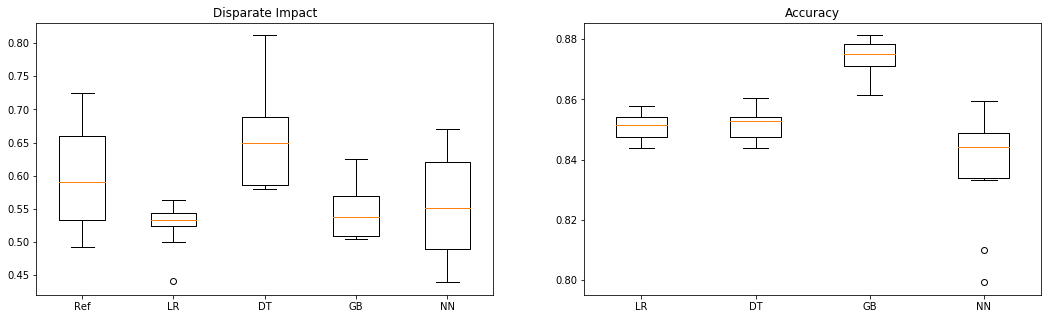

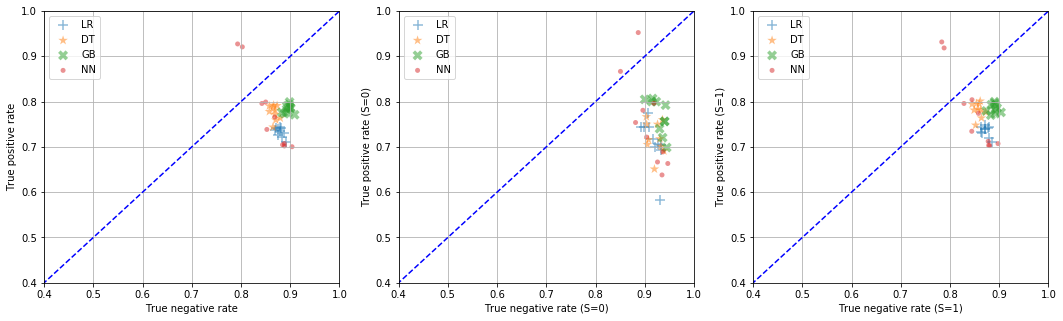

Average rates LR:
 -> True positive (all/S=0/S=1): 0.73 0.71 0.74
 -> True negative (all/S=0/S=1): 0.88 0.92 0.87
Average rates DT:
 -> True positive (all/S=0/S=1): 0.78 0.72 0.78
 -> True negative (all/S=0/S=1): 0.87 0.92 0.86
Average rates GB:
 -> True positive (all/S=0/S=1): 0.78 0.77 0.78
 -> True negative (all/S=0/S=1): 0.9 0.93 0.89
Average rates NN:
 -> True positive (all/S=0/S=1): 0.78 0.75 0.78
 -> True negative (all/S=0/S=1): 0.86 0.91 0.85


In [ ]:
#print("++++++++++++++++++++++++++++++++++++++++++++++++++") 
#print("+          SENSITIVE VARIABLE = OrigEthn         +")
#print("++++++++++++++++++++++++++++++++++++++++++++++++++")

S=X[:,X_col_names.index('OrigEthn')].ravel()


clf_LR = LogisticRegression(solver='lbfgs',max_iter=10000)
clf_DT =DecisionTreeClassifier(max_depth=5)
clf_GB = lgb.LGBMClassifier(random_state=42)
clf_NNref = SimpleNNclassifier()

list_classifiers=[clf_LR,clf_DT,clf_GB,clf_NNref]
list_classifierNames=['LR', 'DT', 'GB', 'NN']
nsplits=10


X_scaled=sk.preprocessing.scale(X)

PreFigNam='StandardOrigEthn'
Make_Kfold_boxplots(list_classifiers,list_classifierNames,S,X_scaled,y,nsplits,PrefixFigNames=PreFigNam)

/home/laurent/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/home/laurent/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/laurent/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/laurent/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the da

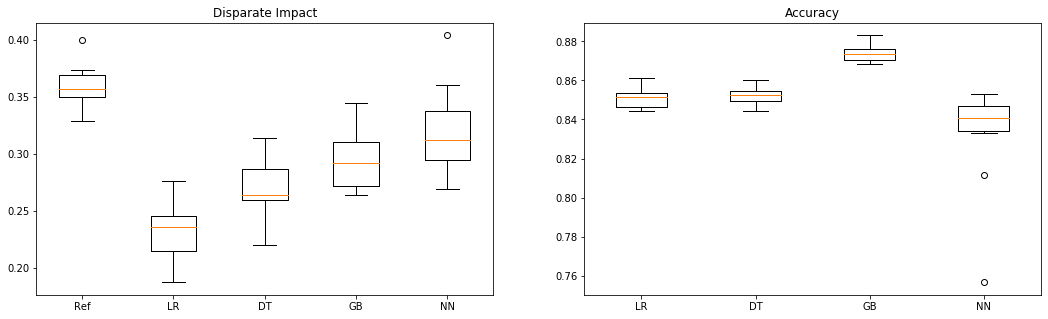

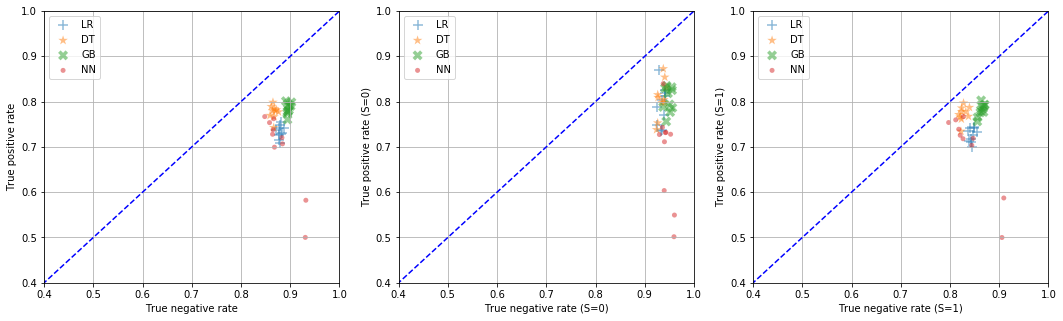

Average rates LR:
 -> True positive (all/S=0/S=1): 0.73 0.79 0.73
 -> True negative (all/S=0/S=1): 0.88 0.93 0.84
Average rates DT:
 -> True positive (all/S=0/S=1): 0.78 0.81 0.77
 -> True negative (all/S=0/S=1): 0.87 0.93 0.83
Average rates GB:
 -> True positive (all/S=0/S=1): 0.78 0.8 0.78
 -> True negative (all/S=0/S=1): 0.9 0.95 0.86
Average rates NN:
 -> True positive (all/S=0/S=1): 0.7 0.69 0.7
 -> True negative (all/S=0/S=1): 0.88 0.94 0.84


In [ ]:
#print("++++++++++++++++++++++++++++++++++++++++++++++++++")
#print("+            SENSITIVE VARIABLE = Sex            +")
#print("++++++++++++++++++++++++++++++++++++++++++++++++++")

S=X[:,X_col_names.index('Sex')]

clf_LR = LogisticRegression(solver='lbfgs',max_iter=10000)
clf_DT =DecisionTreeClassifier(max_depth=5)
clf_GB = lgb.LGBMClassifier(random_state=42)
clf_NNref = SimpleNNclassifier()

list_classifiers=[clf_LR,clf_DT,clf_GB,clf_NNref]
list_classifierNames=['LR', 'DT', 'GB','NN']
nsplits=10


X_scaled=sk.preprocessing.scale(X)

PreFigNam='StandardSex'
Make_Kfold_boxplots(list_classifiers,list_classifierNames,S,X_scaled,y,nsplits,printAverageRes=False,PrefixFigNames=PreFigNam)



As expected, accuracy depends on the algorithm. But the DI as well. The DI is not correlated to the efficiency of the algorithm. 

Remark too, that the Neural Network stategy does not appear to robustely generalize the trained rules. It is very likely that its decision rules overfitted the training data in about 30 percent of the folds. Additional tests with 10 times less epochs have shown that the prediction accuracy was clearly lower by using the neural network strategy than the other strategies (average accuracy approximatively equal to 0.81). As neural networks do not appear to be competitive in these tests, we will only use the other machine learning strategies in the rest of this notebook.


## 4 Correction of unfair machine learning approaches with naive approaches

We will now focus on the variable <i>Sex</i> as the predictions of all tested machine learning algorithms re-enforce the discriminations with respect to this variable. In the following, we will test different <i>naive</i> approaches to try making the predictions more fair. 

### 4.1 What if there was the same amount of Males and Females in the dataset?

A first intuitive explanation for the increase of unfair decisions is that there are more Males than Females in the training set, so the Machine Learning strategies lead to more efficient predictions on Males. We will see below that this phenomenon appears as minor by runing again the computations on data that are well balanced between the amount of Males and Females.




16192 32650


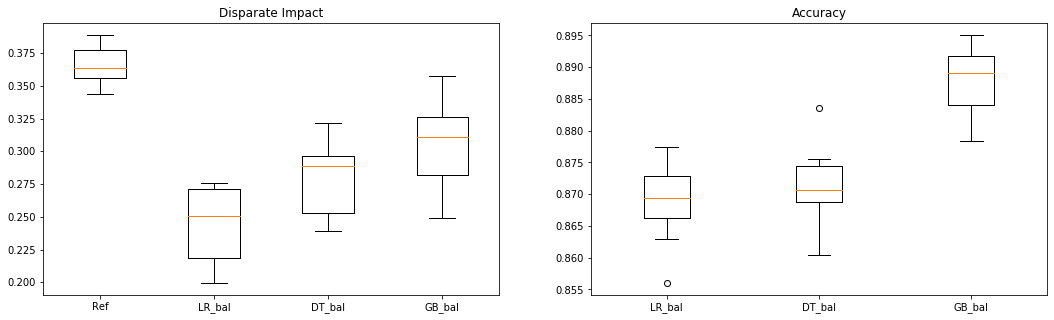

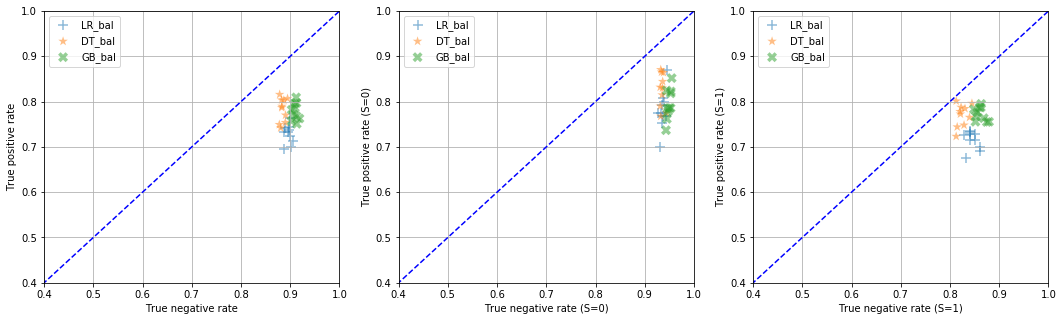

Average rates LR_bal:
 -> True positive (all/S=0/S=1): 0.73 0.78 0.72
 -> True negative (all/S=0/S=1): 0.9 0.94 0.84
Average rates DT_bal:
 -> True positive (all/S=0/S=1): 0.78 0.83 0.77
 -> True negative (all/S=0/S=1): 0.88 0.94 0.82
Average rates GB_bal:
 -> True positive (all/S=0/S=1): 0.78 0.8 0.77
 -> True negative (all/S=0/S=1): 0.91 0.95 0.86


In [ ]:
#print("++++++++++++++++++++++++++++++++++++++++++++++++++")
#print("+    SENSITIVE VARIABLE = Sex  / balanced M/F    +")
#print("++++++++++++++++++++++++++++++++++++++++++++++++++")

S=X[:,X_col_names.index('Sex')]

clf_LR = LogisticRegression(solver='lbfgs',max_iter=10000)
clf_DT =DecisionTreeClassifier(max_depth=5)
clf_GB = lgb.LGBMClassifier(random_state=42)

list_classifiers=[clf_LR,clf_DT,clf_GB]
list_classifierNames=['LR_bal', 'DT_bal', 'GB_bal']
nsplits=10

nb_S0=np.sum(1*(S==0.))
nb_S1=np.sum(1*(S==1.))

print(nb_S0,nb_S1)
X_balanced=np.zeros((2*nb_S0,37))
y_balanced=np.zeros((2*nb_S0,1))
S_balanced=np.zeros((2*nb_S0))

tot_copied_S1=0
tot_copied=0
for i in range(nb_S0+nb_S1):
    if S[i]==0.:
        X_balanced[tot_copied,:]=X[i,:]
        y_balanced[tot_copied,:]=y[i,:]
        S_balanced[tot_copied]=S[i]
        tot_copied+=1
    else:
        if tot_copied_S1<nb_S0:
            X_balanced[tot_copied,:]=X[i,:]
            y_balanced[tot_copied,:]=y[i,:]
            S_balanced[tot_copied]=S[i]
            tot_copied+=1
            tot_copied_S1+=1
        
PreFigNam='BalancedSex'
Make_Kfold_boxplots(list_classifiers,list_classifierNames,S_balanced,X_balanced,y_balanced,nsplits,printAverageRes=False,PrefixFigNames=PreFigNam)


We can remark that both the prediction accuracy and the disparate impacts were slightly improved compare with what we obtained using the original dataset. The undesirable phenomena we observed are however still clearly present in these results. 

### 4.2 What if the sensitive variable is removed?

We train previous algorithms on learning dataset for which we remove the sensitive variable. This could reduce the discrimination as the decision rules used this variable so far.



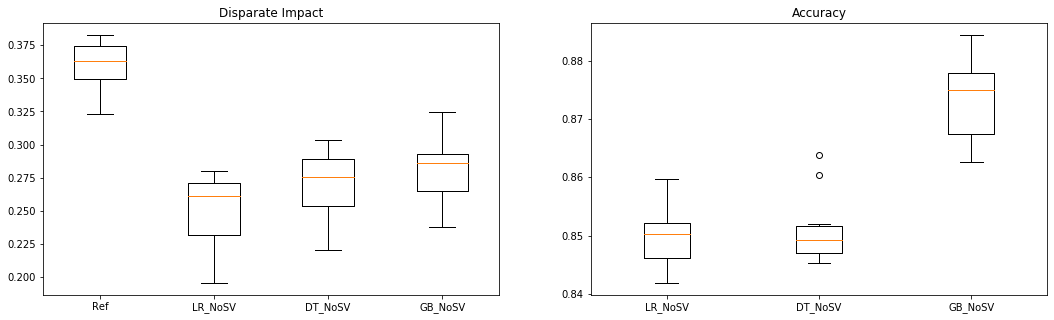

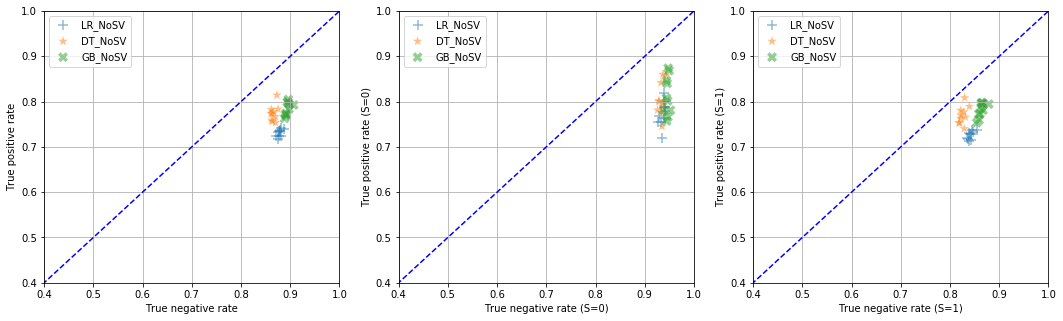

Average rates LR_NoSV:
 -> True positive (all/S=0/S=1): 0.73 0.77 0.73
 -> True negative (all/S=0/S=1): 0.88 0.94 0.84
Average rates DT_NoSV:
 -> True positive (all/S=0/S=1): 0.77 0.81 0.77
 -> True negative (all/S=0/S=1): 0.87 0.93 0.83
Average rates GB_NoSV:
 -> True positive (all/S=0/S=1): 0.78 0.81 0.78
 -> True negative (all/S=0/S=1): 0.9 0.95 0.86
Average D.I. (Average Acc):
LR_NoSV: 0.249(0.85)
DT_NoSV: 0.269(0.851)
GB_NoSV: 0.281(0.873)


In [ ]:
#1) prepare the data and parameters
X_wo_SV=X.copy()
X_wo_SV=np.delete(X_wo_SV,X_col_names.index('Sex'),axis=1)
S=X[:,X_col_names.index('Sex')]
nsplits=10

#2) re-run the K-fold validation with X
#clf_LR = LogisticRegression(solver='lbfgs',max_iter=10000)
#clf_DT =DecisionTreeClassifier(max_depth=5)
#clf_GB = lgb.LGBMClassifier(random_state=42)
#
#list_classifiers=[clf_LR,clf_DT,clf_GB]
#list_classifierNames=['LR', 'DT', 'GB']
#
#Make_Kfold_boxplots(list_classifiers,list_classifierNames,S,X,y,nsplits,printAverageRes=True)

#3) Remove the Sensitive Variable (SV) and run the K-fold validation without the sensitive variable
clf_LR = LogisticRegression(solver='lbfgs',max_iter=10000)
clf_DT =DecisionTreeClassifier(max_depth=5)
clf_GB = lgb.LGBMClassifier(random_state=42)

list_classifiers=[clf_LR,clf_DT,clf_GB]
list_classifierNames=['LR_NoSV', 'DT_NoSV', 'GB_NoSV']

PreFigNam='NoSV'
Make_Kfold_boxplots(list_classifiers,list_classifierNames,S,X_wo_SV,y,nsplits,printAverageRes=True,PrefixFigNames=PreFigNam)


Surprisingly, the accuracies and the disparate impacts remained almost unchanged when removing the variable <i>Sex</i> from the input data X. Hence removing a sensitive variable does not necessarily have the expected effect since it can be highly correlated to other variables. Here, the  variable <i>Sex</i> is included in the correlations with all others. Social determinism is stronger than the presence of the sensitive variable, so the classification algorithms are not necessarily impacted by the removal of the variable.

### 4.3 Testing procedures for unfair prediction

Testing procedures are often used as a legal proof for discrimination. It consists in creating an artificial individual which share the same characteristics but have different protected variable. Such procedures try to highlight individual discrimination. They exist for a long time ago (1939, see for instance in https://fr.wikipedia.org/wiki/Test_de_discrimination). Justice takes it as a proof of biased treatment (https://www.juritravail.com/discrimination-physique/embauche/ph-alternative-A-1.html) since 2016 even if the testing process itself has been qualified as unfair. Moreover testing as a discrimination test is nowadays a commonly used method in France to assess fairness for sociological studies of <a href="http://www.observatoiredesdiscriminations.fr/testing">Observatoire des discriminations</a>, laboratoire TEPP laboratory <a href="http://www.tepp.eu/doc/users/268/bib/banque-et-assurance_9025.pdf">L'Horty et al. (2017)</a>, or governemental stuides <a href="http://dares.travail-emploi.gouv.fr/dares-etudes-et-statistiques/etudes-et-syntheses/dares-analyses-dares-indicateurs-dares-resultats/testing">DARES</a> of French ministry of work <a href="http://www.ismcorum.org/">ISM Corum</a>. Some industries are labeled using such <a href="http://www.ismcorum.org/le-testing-d-entreprise-%E2%80%93-temoignages-d-adecco-casino-lvmh-michael-page-M22-R22-A443.html">test</a>. An <a href="http://www.observatoiredesdiscriminations.fr/diagnostics-qualite">audit quality</a> of recruiting methods is proposed while <a href="https://www.novethic.fr/lexique/detail/testing.html">Novethic</a>, propose ethic formations.

Yet as we will show it testing does not ensure fairness. Worse, an easy trick to bypass testing consists in modifying any algorithm as follows. For each candidate, the outcome will be the best decision of the algorithm run for two cases : the actual characteristic of the candidate and virtual candidate with exactly the same characteristics but with opposite value for the protected variable $S$.

In [ ]:
import copy

class Clf_with_BestPredForTheSV:
    """
    Extension of the classifier ref_clf. When making a prediction for
    a given X_test, the prediction will be made for X_test itself and
    X_test on which the labels of the sensitive variable are swapped.
    The best of these two predictions will be returned for each 
    observation.
    
    * This class is initiated with:
      -> A sklearn classifier (or assimilated)
      -> The column of X representing the sensitive variable. This 
         column must contain labels.
    
    * As in sklearn, the fit method is used to fit X and y.
    
    * As in sklearn, the predict method will used to predict y
    on new observations have the same structure as X.
    """
    
    def __init__(self,ref_clf,col_S_in_X):
        """
        Initiate the model
        """
        try:
            self.ref_clf=sk.clone(ref_clf)   #should work for any sklearn classifier
        except:
            self.ref_clf=copy.deepcopy(ref_clf)    #should work for pytorch classifiers
        self.col_S_in_X=col_S_in_X
    
    
    def fit(self,X,y):
        """
        Initiate the model and fit if
        """
        self.ref_clf.fit(X,y.ravel())


    def predict(self,X_test):
        """
        Perform a prediction as in sklearn but with the best label for the S.V.
        """
        X_test_swp_SV=X_test.copy()
        swp_SV=1.-X_test_swp_SV[:,self.col_S_in_X]
        X_test_swp_SV[:,self.col_S_in_X]=swp_SV

        y_test_pred=self.ref_clf.predict(X_test)
        y_test_pred_swp_SV=self.ref_clf.predict(X_test_swp_SV)

        return np.maximum(y_test_pred,y_test_pred_swp_SV)
    


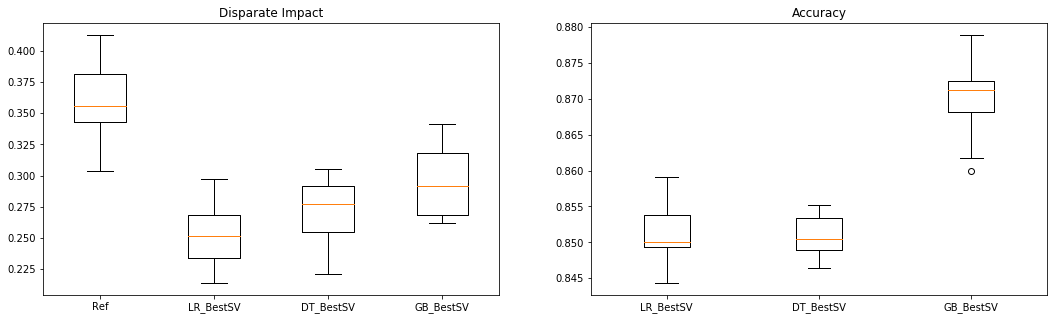

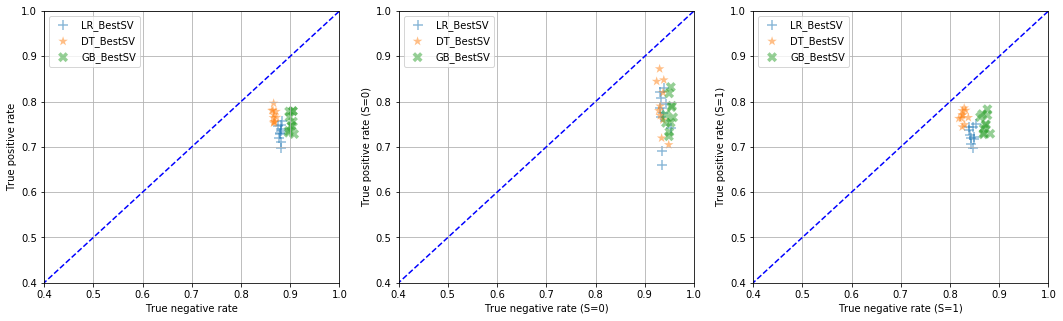

Average rates LR_BestSV:
 -> True positive (all/S=0/S=1): 0.73 0.77 0.73
 -> True negative (all/S=0/S=1): 0.88 0.94 0.84
Average rates DT_BestSV:
 -> True positive (all/S=0/S=1): 0.77 0.79 0.77
 -> True negative (all/S=0/S=1): 0.87 0.93 0.83
Average rates GB_BestSV:
 -> True positive (all/S=0/S=1): 0.75 0.77 0.75
 -> True negative (all/S=0/S=1): 0.9 0.95 0.87
Average D.I. (Average Acc):
LR_BestSV: 0.252(0.851)
DT_BestSV: 0.272(0.851)
GB_BestSV: 0.295(0.87)


In [ ]:
S=X[:,X_col_names.index('Sex')]

clf_LR = LogisticRegression(solver='lbfgs',max_iter=10000)
clf_LR_BSV=Clf_with_BestPredForTheSV(clf_LR,X_col_names.index('Sex'))
    
clf_DT=DecisionTreeClassifier(max_depth=5)
clf_DT_BSV=Clf_with_BestPredForTheSV(clf_DT,X_col_names.index('Sex'))
    
clf_GB = lgb.LGBMClassifier(random_state=42)
clf_GB_BSV=Clf_with_BestPredForTheSV(clf_GB,X_col_names.index('Sex'))


#list_classifiers=[clf_LR,clf_LR_BSV,clf_DT,clf_DT_BSV,clf_GB,clf_GB_BSV]
#list_classifierNames=['LR', 'LR_BestSV', 'DT', 'DT_BestSV', 'GB', 'GB_BestSV']

list_classifiers=[clf_LR_BSV,clf_DT_BSV,clf_GB_BSV]
list_classifierNames=['LR_BestSV', 'DT_BestSV',  'GB_BestSV']

nsplits=10

PreFigNam='BestSV'
Make_Kfold_boxplots(list_classifiers,list_classifierNames,S,X,y,nsplits,printAverageRes=True,PrefixFigNames=PreFigNam)



The classification error does not evolve too much. This appears to have a negligible effect. The effect of the Sex variable on the predictions is then definitively captured in other variables. Removing the effect of the sensitive variable therefore requires more advanced treatments.



### 4.4 Specific classifier for each class of the sensitive variable 


Now a slighly different strategy consists in training the same prediction model with different parameters for each class of the sensitive variable. ...

This obviously makes the  

In [ ]:
class Clf_with_ClassSpecDecRules:
    """
    Extension of the classifier ref_clf for which the parameters 
    learnt will be specific to each class of the sensitive variable 
    (e.g. different logistic regression weights are learnt for 
    males and females). The predictions will naturally depend on the
    class of the sensitive variable. The best prediction may be
    optionnaly returned.
    
    * This class is initiated with:
      -> A sklearn classifier (or assimilated)
      -> The column of X representing the sensitive variable. This 
         column must contain labels (the structure of X_train and
         X_test in the fit and predict methods must be coherent
         with this choice).
      -> ReturnBestPred (=False) to optionally return the best 
      prediction.

    * As in sklearn, the fit method is used to fit X and y.
    
    * As in sklearn, the predict method will used to predict y
    on new observations have the same structure as X.
    """
    
    def __init__(self,ref_clf,col_S_in_X,ReturnBestPred=False):
        """
        Initiate the model
        """
        self.ref_clf=ref_clf
        self.col_S_in_X=col_S_in_X
        self.ReturnBestPred=ReturnBestPred
    
    
    def fit(self,X,y,verbose=False):
        """
        Initiate the model and fit it
        """
        
        #extract the sensitive variable and its classes
        S=X[:,self.col_S_in_X].ravel()
        self.S_classes=set(S)
        if verbose==True:
          print("Classes found in S: ",self.S_classes)
        
        #remove the sensitive variable from X
        X_wo_SV=X.copy()
        #X_wo_SV=np.delete(X_wo_SV,self.col_S_in_X,axis=1)
        
        #instantiate and train class-specific classifiers
        self.DictClassSpec_Clfs={}
        for classLabel in self.S_classes:
            if verbose==True:
                print('Instanciate and train the model for class '+str(classLabel))
            try:
                self.DictClassSpec_Clfs[classLabel]=sk.clone(self.ref_clf)   #should work for any sklearn classifier
            except:
                self.DictClassSpec_Clfs[classLabel]=copy.deepcopy(self.ref_clf)    #should work for pytorch classifiers
            X_filtered = X_wo_SV[S==classLabel,:]
            y_filtered = y[S==classLabel]
            self.DictClassSpec_Clfs[classLabel].fit(X_filtered,y_filtered.ravel())
        
        if verbose==True:
            print('Done')
    
    def predict(self,X_test):
        """
        Perform a prediction as in sklearn
        
        If the option ReturnBestModel is false then each y is predicted 
        using the model corresponding to the value of the corresponding
        sensitive variable. If true, the best y using all possible 
        labels of the sensitive variable is returned.
        """
        
        #remove the sensitive variable from X_test
        S_tst=X_test[:,self.col_S_in_X].ravel()
        X_wo_SV=X_test.copy()
        #X_wo_SV=np.delete(X_wo_SV,self.col_S_in_X,axis=1)
        
        #perform the predictions for each class-specific-classifier
        self.DictClassSpec_y_pred={}
        for classLabel in self.S_classes:
            self.DictClassSpec_y_pred[classLabel]=self.DictClassSpec_Clfs[classLabel].predict(X_wo_SV)
        
        #aggregate the predictions
        y_pred=np.zeros(X_test.shape[0])
        if self.ReturnBestPred==False:
            for i in range(X_test.shape[0]):  #could be parallelized for sure
                y_pred[i]=self.DictClassSpec_y_pred[S_tst[i]][i]
        else:
            for i in range(X_test.shape[0]):
                for classLabel in self.S_classes:
                    if self.DictClassSpec_y_pred[classLabel][i]>y_pred[i]:
                        y_pred[i]=self.DictClassSpec_y_pred[classLabel][i]
        
        return y_pred
    


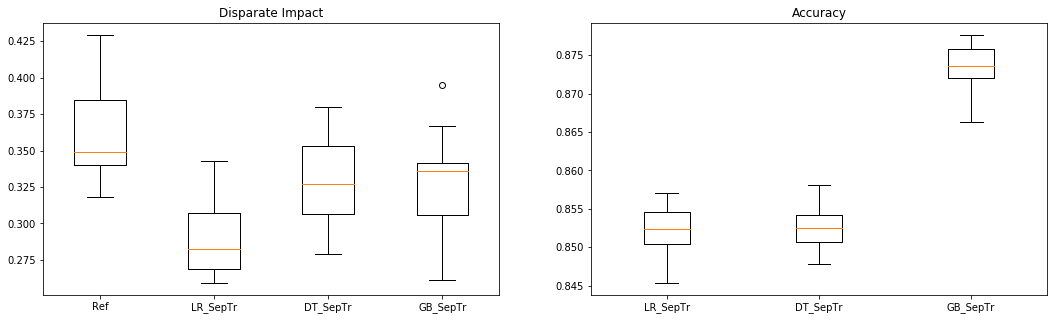

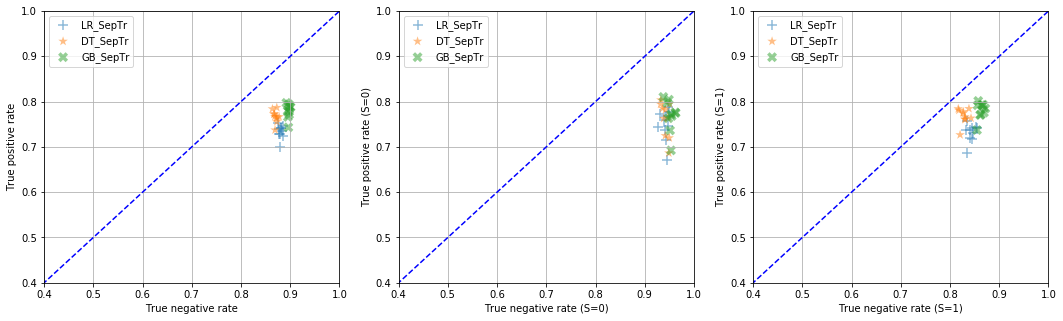

Average rates LR_SepTr:
 -> True positive (all/S=0/S=1): 0.73 0.75 0.73
 -> True negative (all/S=0/S=1): 0.88 0.94 0.84
Average rates DT_SepTr:
 -> True positive (all/S=0/S=1): 0.77 0.76 0.77
 -> True negative (all/S=0/S=1): 0.87 0.94 0.83
Average rates GB_SepTr:
 -> True positive (all/S=0/S=1): 0.78 0.77 0.78
 -> True negative (all/S=0/S=1): 0.9 0.95 0.86


In [ ]:
S=X[:,X_col_names.index('Sex')]

clf_LR = LogisticRegression(solver='lbfgs',max_iter=10000)
clf_LR_CS=Clf_with_ClassSpecDecRules(clf_LR,X_col_names.index('Sex'),ReturnBestPred=False)
    
clf_DT=DecisionTreeClassifier(max_depth=5)
clf_DT_CS=Clf_with_ClassSpecDecRules(clf_DT,X_col_names.index('Sex'),ReturnBestPred=False)
    
clf_GB = lgb.LGBMClassifier(random_state=42)
clf_GB_CS=Clf_with_ClassSpecDecRules(clf_GB,X_col_names.index('Sex'),ReturnBestPred=False)


#list_classifiers=[clf_LR,clf_LR_CS,clf_DT,clf_DT_CS,clf_GB,clf_GB_CS]
#list_classifierNames=['LR', 'LR_SepTr', 'DT', 'DT_SepTr', 'GB', 'GB_SepTr']

list_classifiers=[clf_LR_CS,clf_DT_CS,clf_GB_CS]
list_classifierNames=['LR_SepTr', 'DT_SepTr', 'GB_SepTr']

nsplits=10

PreFigNam='SepTr'
Make_Kfold_boxplots(list_classifiers,list_classifierNames,S,X,y,nsplits,PrefixFigNames=PreFigNam)


Splitting the model parameters into parameters adapted to each group appears as the best solution. In all cases, it improved the disparate impact for relatively stable prediction accuracies. Note that the improvements are more spectacular for the basic <i>Logistic Regression</i> and <i>Decision tree</i> models than for the <i>Gradient Boosting</i> model. This last model is indeed particularly efficient to capture fine high order relations between the variables, which gives less influence to the strong non-linearity generated when splitting the M.L. model into two class-specific M.L. models.

Now making the disparate impact at least similar or even better to the one observed on the reference data requires more advanced methods. This is work in progress...


### 4.5 Specific thresholds for each class of the sensitive variable 

We now test an alternative strategy to the previous one, where a single classifier is trained for all data but the threshold used one the output probability is not necessarily 0.5, but is adapted to avoid the discriminations. 

In practice here:
<ul>
<li>We keep a threshold of 0.5 for the observations with S=1.</li> 
<li>If the D.I. is below 0.8, we adapt the threshold for the observations with S=0 to make the D.I. close to 0.8.</li> 
</ul>


In [ ]:
class Clf_with_AdaptiveThreshForS0:
    """
    Extension of the classifier ref_clf for which the threshold
    to get y=1 is potentially adapted on the class S=0. The 
    threshold will be adapted when the D.I. is below 0.8, in order
    to make it close to 0.8.
    
    * This class is initiated with:
      -> A sklearn classifier (or assimilated)
      -> The column of X representing the sensitive variable. This 
         column must contain labels (the structure of X_train and
         X_test in the fit and predict methods must be coherent
         with this choice).

    * As in sklearn, the fit method is used to fit X and y.
    
    * As in sklearn, the predict method will used to predict y
    on new observations have the same structure as X.
    """
    
    def __init__(self,ref_clf,col_S_in_X,AdaptOnTestSet=False,DI_to_reach=0.8):
        """
        Initiate the model
        """
        try:
            self.ref_clf=sk.clone(ref_clf)   #should work for any sklearn classifier
        except:
            self.ref_clf=copy.deepcopy(ref_clf)    #should work for pytorch classifiers
        self.col_S_in_X=col_S_in_X
        self.AdaptOnTestSet=AdaptOnTestSet
        self.threshForS0=0.5
        self.DI_to_reach=DI_to_reach

        
    def _cpt_y_loc_pred(self,X_loc,S_loc):
        y_loc_pred_probaEq0=self.ref_clf.predict_proba(X_loc)[:,0]
        
        y_loc_pred__S_eq_0=1*(y_loc_pred_probaEq0<self.threshForS0)
        y_loc_pred=1*(y_loc_pred_probaEq0<0.5)   #for S=1 in the end
        for i in range(X_loc.shape[0]):
            if S_loc[i]<0.5:
                y_loc_pred[i]=y_loc_pred__S_eq_0[i]
        return y_loc_pred
        
        
        
    def _adaptThresh(self,X_loc):
        S_loc=X_loc[:,self.col_S_in_X].ravel()

        y_loc_pred=self._cpt_y_loc_pred(X_loc,S_loc)
        [DI_clf,ICg,ICd]=dispImp(S_loc.ravel(),y_loc_pred.ravel())
        
        if DI_clf>self.DI_to_reach:
            #print(" -> Threshold not changed as DI ="+str(DI_clf))
            DI_clf_init=DI_clf
        else:
            DI_clf_init=DI_clf
            shift=0.25
            iteration=0
            Finished=False
            self.threshForS0=0.5
            while Finished==False:
                #... update the threshold
                if DI_clf<self.DI_to_reach:
                    PrevThreshForS0=self.threshForS0
                    self.threshForS0+=shift
                else:
                    PrevThreshForS0=self.threshForS0
                    self.threshForS0-=shift
                shift/=2.
                
                #... compute the new D.I.
                y_loc_pred=self._cpt_y_loc_pred(X_loc,S_loc)
                [DI_clf,ICg,ICd]=dispImp(S_loc.ravel(),y_loc_pred.ravel())
                
                #... manage the end of the lood
                iteration+=1
                if iteration>10:
                    Finished=True
                if np.isnan(DI_clf) or DI_clf>1.2 or DI_clf<0:
                    Finished=True
                    self.threshForS0=PrevThreshForS0
                    y_loc_pred=self._cpt_y_loc_pred(X_loc,S_loc)
                    [DI_clf,ICg,ICd]=dispImp(S_loc.ravel(),y_loc_pred.ravel())
                    
            #print(" -> Threshold changed to: "+str(self.threshForS0)+". The D.I was "+str(DI_clf_init)+" and is now "+str(DI_clf)+".")

    
    def fit(self,X,y):
        """
        Initiate the model and fit if
        """
        #1) learn the classifier
        self.ref_clf.fit(X,y.ravel())
        
        #2) find the optimal threshold
        #print('Fit')
        self._adaptThresh(X)
        
    
    def predict(self,X_test):
        """
        Perform a prediction as in sklearn but with potentially adapted threshold for S=0
        """
        #eventually adapt threshForS0
        if self.AdaptOnTestSet==True:   
            #print('Pred')
            self._adaptThresh(X_test)

        #compute the proba to have Y=0 
        y_test_pred_probas=self.ref_clf.predict_proba(X_test)
        y_test_pred_probaEq0=y_test_pred_probas[:,0]
        
        
        #threshold this probability
        y_test_pred_S0=1*(y_test_pred_probaEq0<self.threshForS0)
        y_test_pred_S1=1*(y_test_pred_probaEq0<0.5)
        
        #merge the results in the two groups
        S_test=X_test[:,self.col_S_in_X].ravel()
        y_test_pred=y_test_pred_S1.copy()
        for i in range(X_test.shape[0]):
            if S_test[i]<0.5:
                y_test_pred[i]=y_test_pred_S0[i]

        return y_test_pred


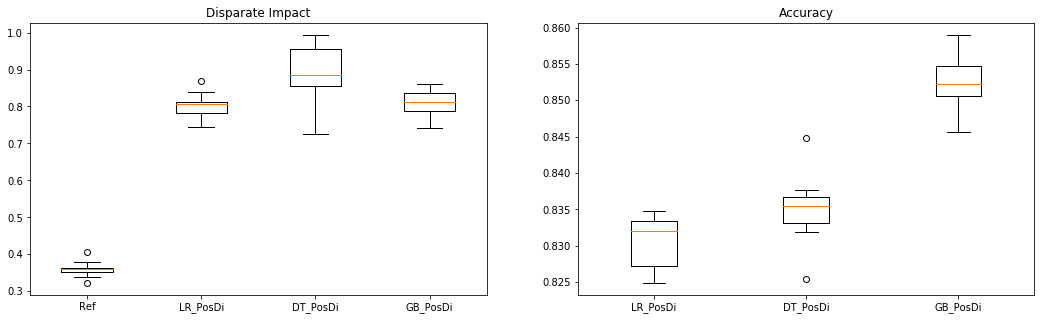

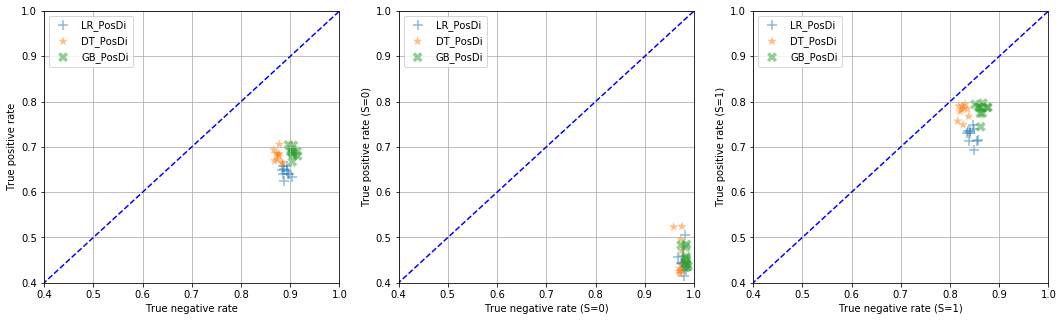

Average rates LR_PosDi:
 -> True positive (all/S=0/S=1): 0.64 0.44 0.73
 -> True negative (all/S=0/S=1): 0.89 0.98 0.84
Average rates DT_PosDi:
 -> True positive (all/S=0/S=1): 0.68 0.46 0.78
 -> True negative (all/S=0/S=1): 0.88 0.97 0.83
Average rates GB_PosDi:
 -> True positive (all/S=0/S=1): 0.69 0.46 0.78
 -> True negative (all/S=0/S=1): 0.91 0.98 0.86
Average confusion matrices:
LR_PosDi: 
[[0.67423529 0.08648295]
 [0.08281807 0.1564637 ]]

DT_PosDi: 
[[0.69454568 0.06617256]
 [0.09872651 0.14055526]]

GB_PosDi: 
[[0.68484092 0.07587732]
 [0.07155727 0.1677245 ]]



In [ ]:
S=X[:,X_col_names.index('Sex')]

clf_LR = LogisticRegression(solver='lbfgs',max_iter=10000)
clf_LR_AdapThresh=Clf_with_AdaptiveThreshForS0(clf_LR,X_col_names.index('Sex'))
    
clf_DT=DecisionTreeClassifier(max_depth=5)
clf_DT_AdapThresh=Clf_with_AdaptiveThreshForS0(clf_DT,X_col_names.index('Sex'))
    
clf_GB = lgb.LGBMClassifier(random_state=42)
clf_GB_AdapThresh=Clf_with_AdaptiveThreshForS0(clf_GB,X_col_names.index('Sex'))


#list_classifiers=[clf_LR,clf_LR_AdapThresh,clf_DT,clf_DT_AdapThresh,clf_GB,clf_GB_AdapThresh]
#list_classifierNames=['LR', 'LR_PosDi', 'DT', 'DT_PosDi', 'GB', 'GB_PosDi']

list_classifiers=[clf_LR_AdapThresh,clf_DT_AdapThresh,clf_GB_AdapThresh]
list_classifierNames=[ 'LR_PosDi',  'DT_PosDi',  'GB_PosDi']

nsplits=10

PreFigNam='PosDi'
Make_Kfold_boxplots(list_classifiers,list_classifierNames,S,X,y,nsplits,printAverageConfusionMatrices=True,PrefixFigNames=PreFigNam)


By changing the thresholds with which $Y=1$ is predicted in the group $S=0$, we have been able to make the D.I. even better than the one observed in the orginal data. Remark that in all cases, changing the threshold however lowered the prediction accuracy.

To study this effect in detail, we represented the average confusion matrices obtained in each group, where the represented rates are:

$$
\left(
\begin{array}{cc}
True  Negatives &False  Positives\\
False  Negatives &True  Positives\\
\end{array}
\right)
$$

In average, the number of false negative predictions decreased of about $13\%$ and the number of false positive predictions increased of about $76\%$. The increase of false positive predictions is then particularly high with regard to the fact that the threshold was applied on about $33\%$ of the observations (those with $S=0$).


## 5 Summary

To summarize this section, here is below an overview of all the disparate impacts obtained in this section. In addition to the results already shown above, we also tested the method of section 4.4 with modified thresholds to get a disparate impact slighly higher than the one observed in the data, and not only a disparate impact close to 0.8. This allows to assess this method with reasonable changes of the threshold.


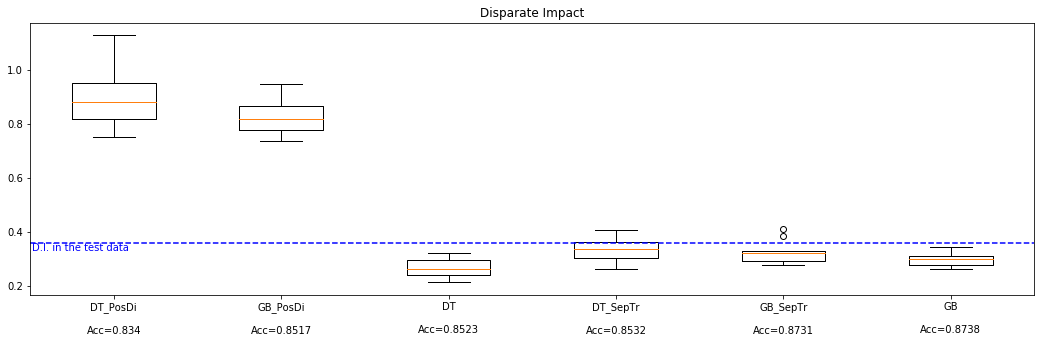

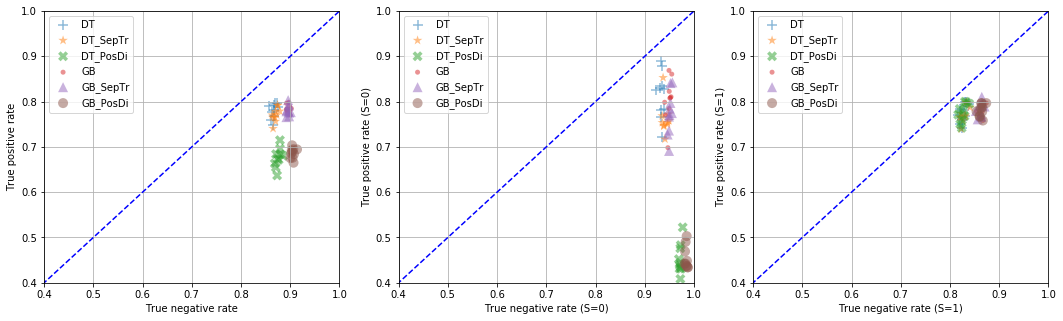

Average rates DT:
 -> True positive (all/S=0/S=1): 0.78 0.81 0.78
 -> True negative (all/S=0/S=1): 0.87 0.93 0.83
Average rates DT_SepTr:
 -> True positive (all/S=0/S=1): 0.77 0.76 0.77
 -> True negative (all/S=0/S=1): 0.87 0.94 0.83
Average rates DT_PosDi:
 -> True positive (all/S=0/S=1): 0.68 0.45 0.78
 -> True negative (all/S=0/S=1): 0.88 0.97 0.83
Average rates GB:
 -> True positive (all/S=0/S=1): 0.78 0.8 0.78
 -> True negative (all/S=0/S=1): 0.9 0.95 0.86
Average rates GB_SepTr:
 -> True positive (all/S=0/S=1): 0.78 0.77 0.78
 -> True negative (all/S=0/S=1): 0.9 0.95 0.86
Average rates GB_PosDi:
 -> True positive (all/S=0/S=1): 0.69 0.45 0.78
 -> True negative (all/S=0/S=1): 0.91 0.98 0.86


In [ ]:
    
S=X[:,X_col_names.index('Sex')]

clf_LR = LogisticRegression(solver='lbfgs',max_iter=10000)
clf_LR_CS=Clf_with_ClassSpecDecRules(clf_LR,X_col_names.index('Sex'),ReturnBestPred=False)
clf_LR_AdapThresh=Clf_with_AdaptiveThreshForS0(clf_LR,X_col_names.index('Sex'))

clf_DT=DecisionTreeClassifier(max_depth=5)
clf_DT_CS=Clf_with_ClassSpecDecRules(clf_DT,X_col_names.index('Sex'),ReturnBestPred=False)
clf_DT_AdapThresh=Clf_with_AdaptiveThreshForS0(clf_DT,X_col_names.index('Sex'))
    
clf_GB = lgb.LGBMClassifier(random_state=42)
clf_GB_CS=Clf_with_ClassSpecDecRules(clf_GB,X_col_names.index('Sex'),ReturnBestPred=False)
clf_GB_AdapThresh=Clf_with_AdaptiveThreshForS0(clf_GB,X_col_names.index('Sex'))


"""
list_classifiers=[clf_LR,clf_LR_CS,clf_LR_AdapThresh,
                  clf_DT,clf_DT_CS,clf_DT_AdapThresh,
                  clf_GB,clf_GB_CS,clf_GB_AdapThresh]
list_classifierNames=['LR','LR_SepTr','LR_PosDi',
                      'DT','DT_SepTr','DT_PosDi',
                      'GB','GB_SepTr','GB_PosDi']
"""

list_classifiers=[clf_DT,clf_DT_CS,clf_DT_AdapThresh,
                  clf_GB,clf_GB_CS,clf_GB_AdapThresh]
list_classifierNames=['DT','DT_SepTr','DT_PosDi',
                      'GB','GB_SepTr','GB_PosDi']

nsplits=10



PreFigNam='Summary'
Make_Kfold_boxplots(list_classifiers,list_classifierNames,S,X,y,nsplits,Show_DI_boxPlotsOnly=True,PrefixFigNames=PreFigNam)


Note that the boxplots above are ranked from left to right with increasing predicion accuracies. These results lead to several conclusions:
<ul>
    <li>In all tested cases, <i>Gradient Boosting</i> (GB) was more accurate than <i>Decision Trees</i> (DT), and DT was more accurate than <i>Logistic Regression</i> (LR).</li>
    <li>All methods with the original thresholds of 0.5 on the predicted success probability had average <i>discriminate impacts</i> (DI) lower to the average DI measured on the test data (about 0.36).</li>
    <li>Stronly modifying the thresholds for which the predictions leading to a success in the class $S=0$ makes it possible to reach <i>DIs</i> of 0.8. This was however at the expense of clearly lowered prediction accuracies.</li>
    <li>Splitting the prediction models for the observations with $S=0$ and those with $S=1$ simultaneously allowed to increase the <i>DI</i> and the prediction accuracy for <i>DT</i> and <i>LR</i>. For <i>GB</i>, the <i>DI</i> was improved for a very slighly lower prediction accuracy.</li>
</ul>


### References

Barocas S., Selbst A. (2016). Big Data's Disparate Impact, California Law Review, 671.

Dan Biddle (2005). Adverse Impact And Test Validation: A Practitioner's Guide to Valid And Defensible Employment Testing. Aldershot, Hants, England: Gower Technical Press. 

Hardt M., Price E., Srebro N. (2016). Equality of Opportunity in Supervised Learning. Proceedings of NIPS'16.

Besse P. ,del Barrio E., Gordaliza P., Loubes J.-M. (2018). Confidence Intervals for testing Disparate Impact in Fair Learning, <a href="https://arxiv.org/abs/1807.06362">arXiv</a>.

Calders T., Verwer S. (2010). Three naive Bayes approaches for discrimination-free classification, Data Mining and Knowledge Discovery, 21 (2), pp 277–292.

Friedler S., Scheidegger C., Venkatasubramanian S., Choudhary S., Hamilton E., Roth D. (2019). A comparative study of fairness-enhancing interventions in machine learning, Proceedings of the Conference on Fairness, Accountability, and Transparency.

Verma S., Rubin J. (2018). <a href="http://fairware.cs.umass.edu/papers/Verma.pdf">Fairness Definitions Explained</a>, ACM/IEEE International Workshop on Software Fairness.

